# Analysis of Conv512 against Conv32

In this notebook, we analyzed the impact of the kernel in the initial layer *Layer0* for a mrw, woth parameters $H = 0.8$ and $\lambda^2 = 0.03$.

##### Import librairies

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import os
import datetime
import numpy as np
from time import time, strftime
import pandas as pd
import statsmodels.api as sm

from plot_result import Analysis_sf, Analysis_m, comparison_Analysis
from fbm import fbm

from training import Trainer

import seaborn as sns
sns.set(style="darkgrid")

##### Declare variables

In [2]:
latent_dim = 2**12
ts_dim = 2**12
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 15000
n = 3
batch_size = 128

In [3]:
def complet_training(n, savepath, namepath, latent_dim, ts_dim, epochs, device):
    generators = []
    discriminators = []
    trainers = []
    synthetic_datas = []
    plot_result_sf = []
    plot_result_m = []
    
    # Create Scorepath
    scorepath = os.path.join(r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output',savepath)
    if not os.path.exists(scorepath):
        os.makedirs(scorepath)
    
    # Init parameters
    lr_a = 1e-4
    lr_b = 1e-4
    
    # Exportation true data
    true_data = torch.tensor(pd.read_csv('data_train' + namepath).to_numpy().astype('float32')).to(device)
    
    for i in range (n):
        
        print('.....')
        print('New Training')
        print('.....')
        
        data_train = true_data[np.random.randint(low = 0, high = true_data.cpu().shape[0], size = 10000)]
        
        generator = Generator().to(device)
        discriminator = Discriminator(ts_dim = ts_dim).to(device)
        
        # Init optimizers
        G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
        D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

        # Training
        path = os.path.join(scorepath, 'Training n° ' + str(i+1)) 
        if not os.path.exists(path):
            os.makedirs(path)
        train = Trainer(generator, discriminator, G_opt, D_opt, batch_size, latent_dim, ts_dim, data_train, device, path)
        train.train(epochs=epochs)
        
        # Save models
        noise = torch.normal(mean = 0, std = 0.3, size = (10000, latent_dim)).to(device)
        synthetic_data = generator(noise).cpu()
        with torch.no_grad():
            x = synthetic_data[np.random.randint(low = 0, high = 10000)]
            plt.plot(x, )
            plt.title('Sample of synthetic data GAN n°' + str(i+1))
            plt.show()
            sm.graphics.tsa.plot_acf(x.detach().numpy(), lags=100, zero = False)
            plt.show()
 
        plot_analysis_m = Analysis_m(data_train, synthetic_data, path)
        plot_analysis_sf = Analysis_sf(data_train, synthetic_data, path)
        plot_analysis_m.dataFrame()
        plot_analysis_m.boxplot()
        plot_analysis_sf.plot()
        df_data, df_synthetic = plot_analysis_sf.dataFrame()
        
        generators.append(generator.cpu())
        discriminators.append(discriminator.cpu())
        trainers.append(train)
        synthetic_datas.append(synthetic_data.cpu())
        plot_result_sf.append(plot_analysis_sf)
        plot_result_m.append(plot_analysis_m)
        
    return generators, discriminators, trainers, synthetic_datas, plot_result_sf, plot_result_m

### Case 1 : kernel_size = 512

In [6]:
from torch.nn.parameter import Parameter
class btanha(nn.Module):
    
    def __init__(self, alpha = None, beta = None, initialisation = 0.5):
        super(btanha,self).__init__()
        
        self.tanh = nn.Tanh()
        
        if alpha == None :
            self.alpha = Parameter(torch.tensor(initialisation))
        else :
            self.alpha = Parameter(torch.tensor(alpha))
        self.alpha.requiresGrad = True
        
        if beta == None :
            self.beta = Parameter(torch.tensor(initialisation))
        else :
            self.beta = Parameter(torch.tensor(alpha))
        self.beta.requiresGrad = True
        
    def forward(self,x): 
        return self.beta* self.tanh(self.alpha * x)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv0 = nn.Conv1d(1, 1, kernel_size = 512, padding = 'same')
        self.batch0 = nn.BatchNorm1d(1)
        
        self.conv1 = nn.ConvTranspose1d(8, 4, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch1 = nn.BatchNorm1d(4)
        self.conv2 = nn.ConvTranspose1d(4, 2, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch2 = nn.BatchNorm1d(2)
        self.conv3 = nn.ConvTranspose1d(2, 1, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch3 = nn.BatchNorm1d(1)
        self.tanh = btanha()


    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = self.conv0(x)
        x = self.batch0(x)
        x = F.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], 8, x.shape[2]//8)

        x = self.batch1(self.conv1(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch2(self.conv2(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch3(self.conv3(x))
        x = x.squeeze()
        return self.tanh(x)
    


class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.ts_dim = ts_dim
        self.conv1 = nn.Conv1d(1, 32, kernel_size = 7, padding = 'same')
        self.conv2 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same')
        self.conv3 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same') 
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear(self.ts_dim*8, 50) 
        self.dense2 = nn.Linear(50, 15)
        self.dense3 = nn.Linear(15, 1)    
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.max_pool1d(x,1)
        x = self.flatten(x)
        x = F.leaky_relu(self.dense1(x), 0.2)
        x = F.leaky_relu(self.dense2(x), 0.2)
        return F.leaky_relu(self.dense3(x), 0.2)

.....
New Training
.....


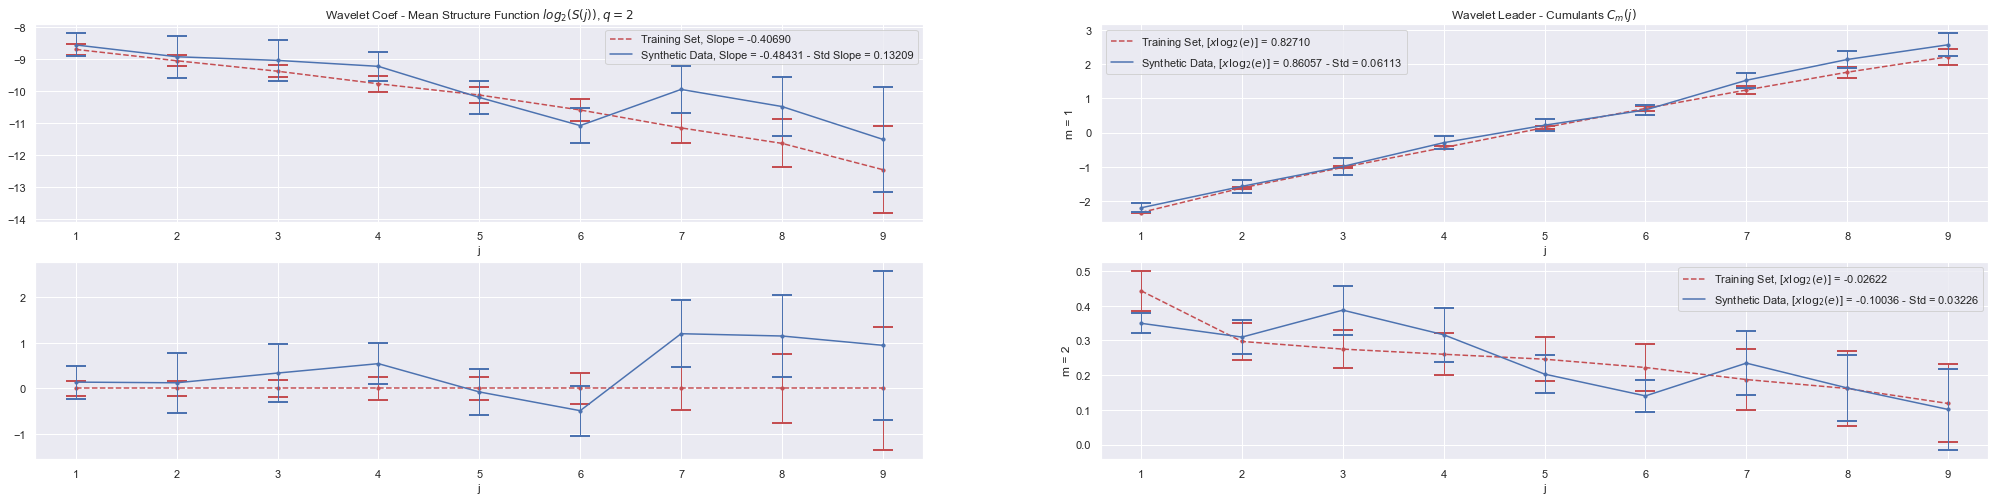

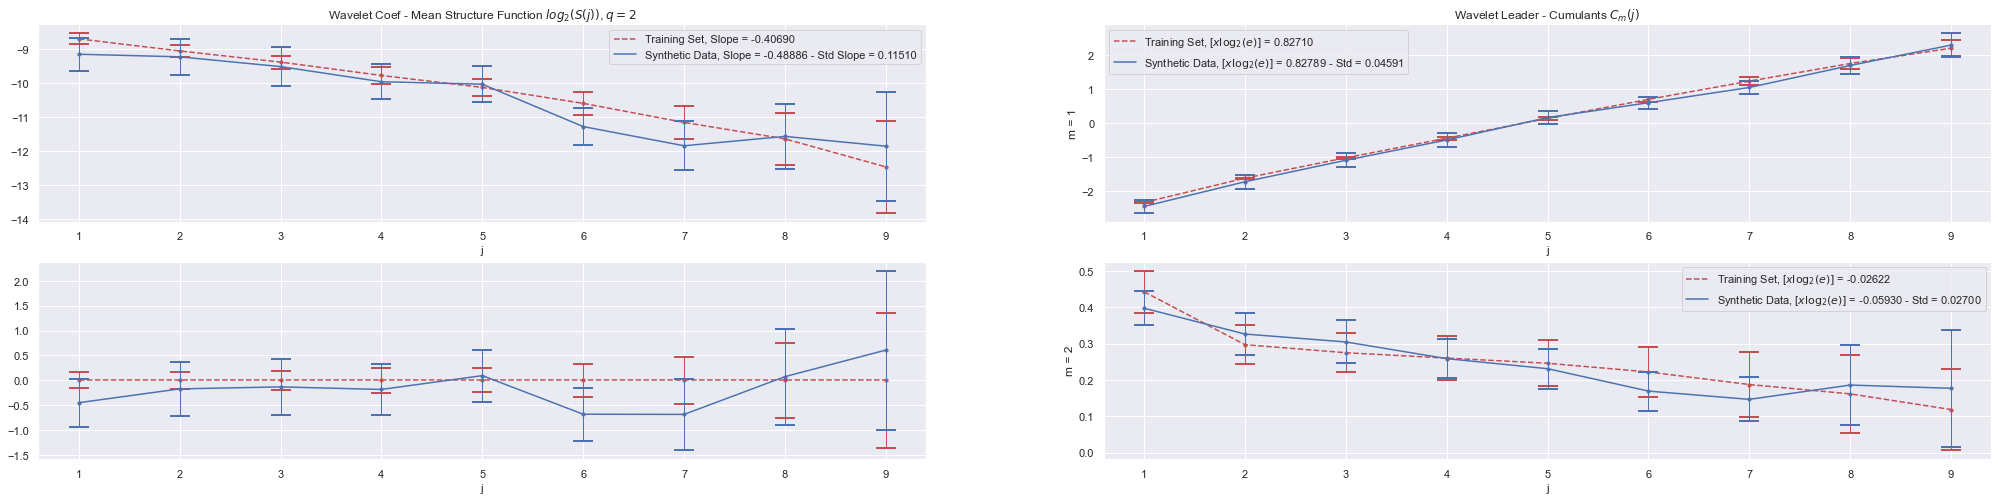

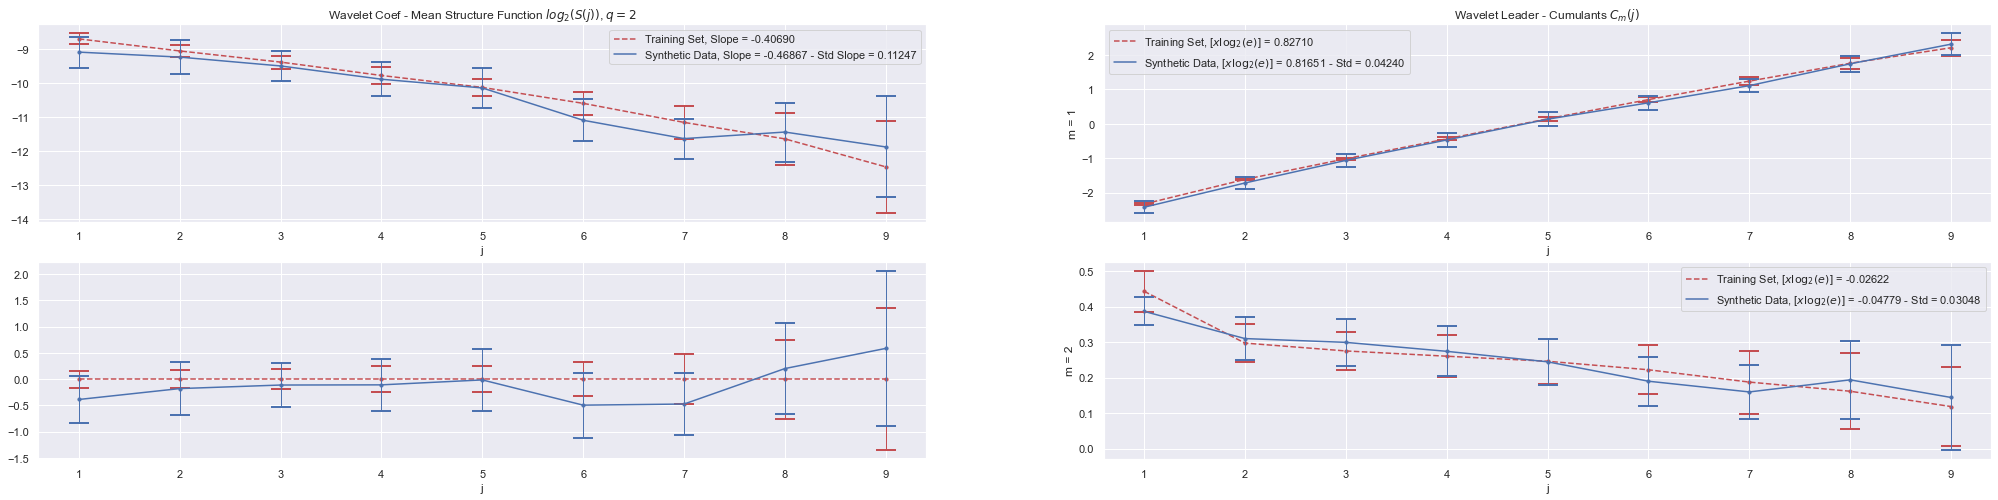

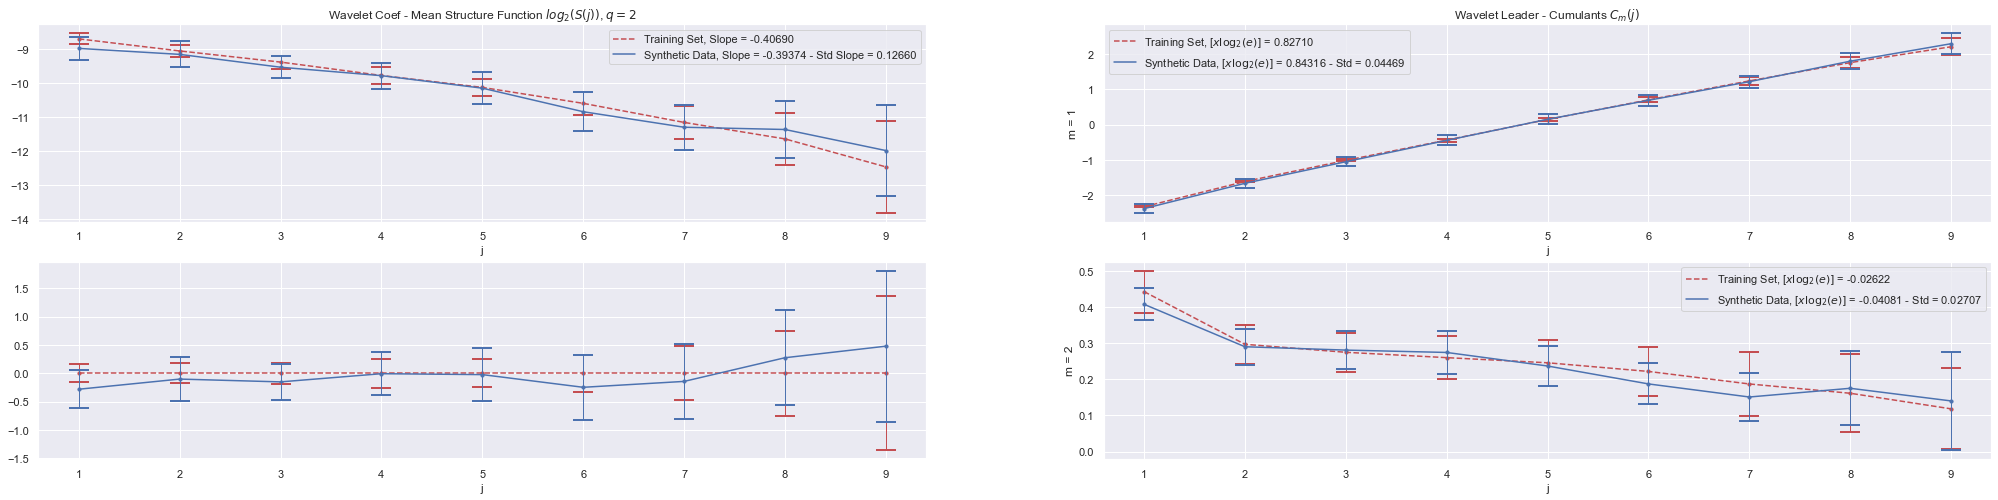

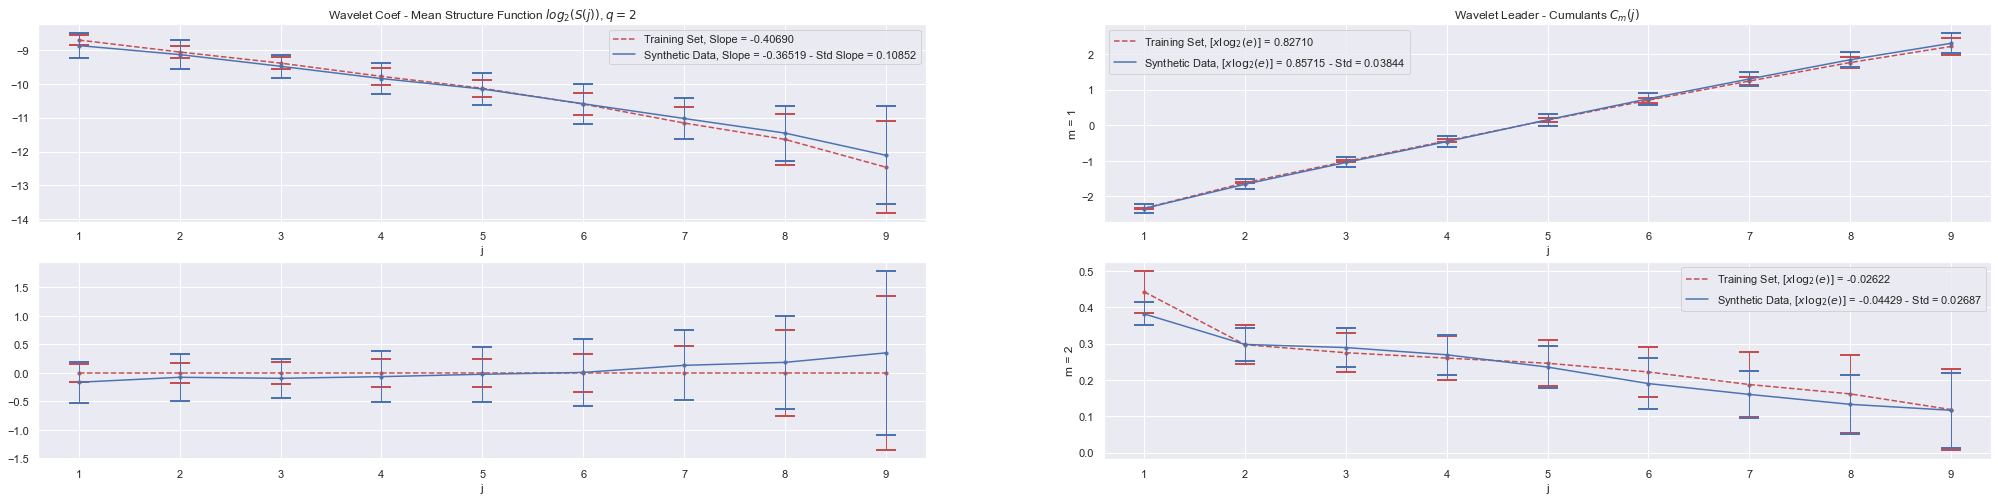

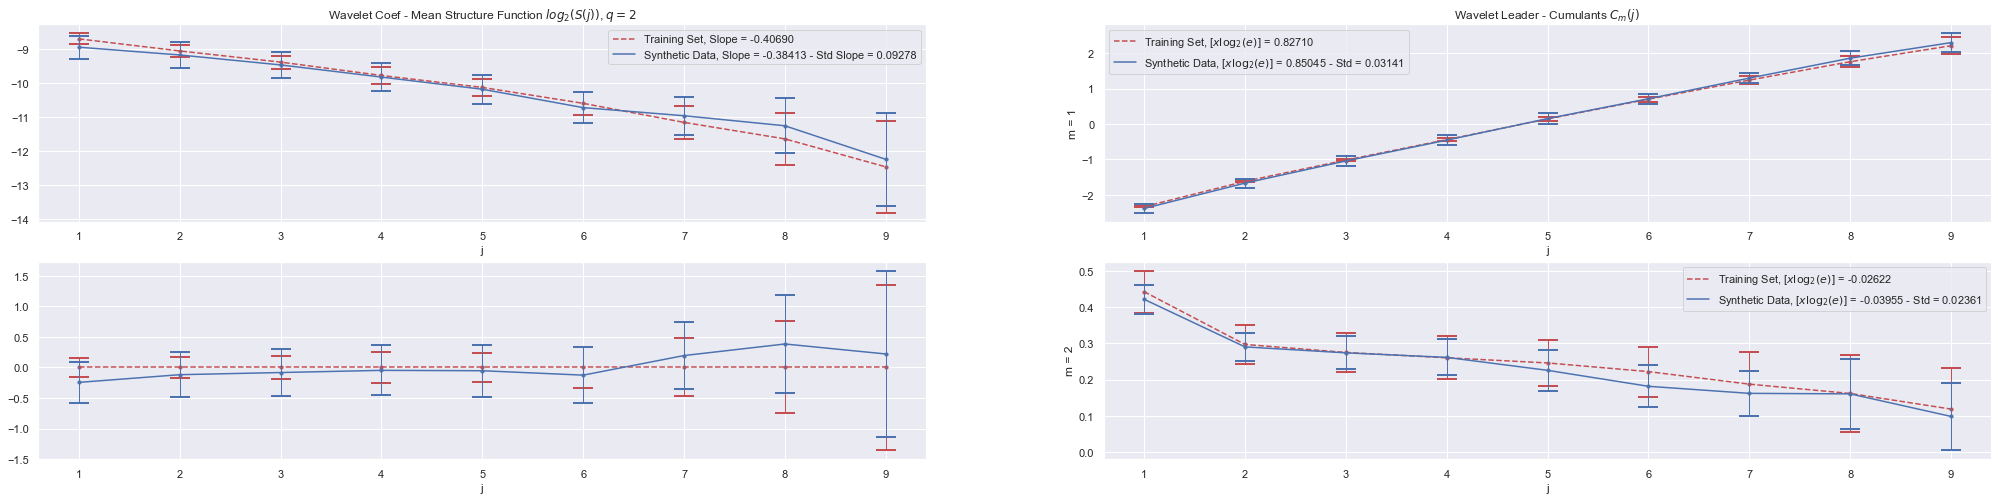

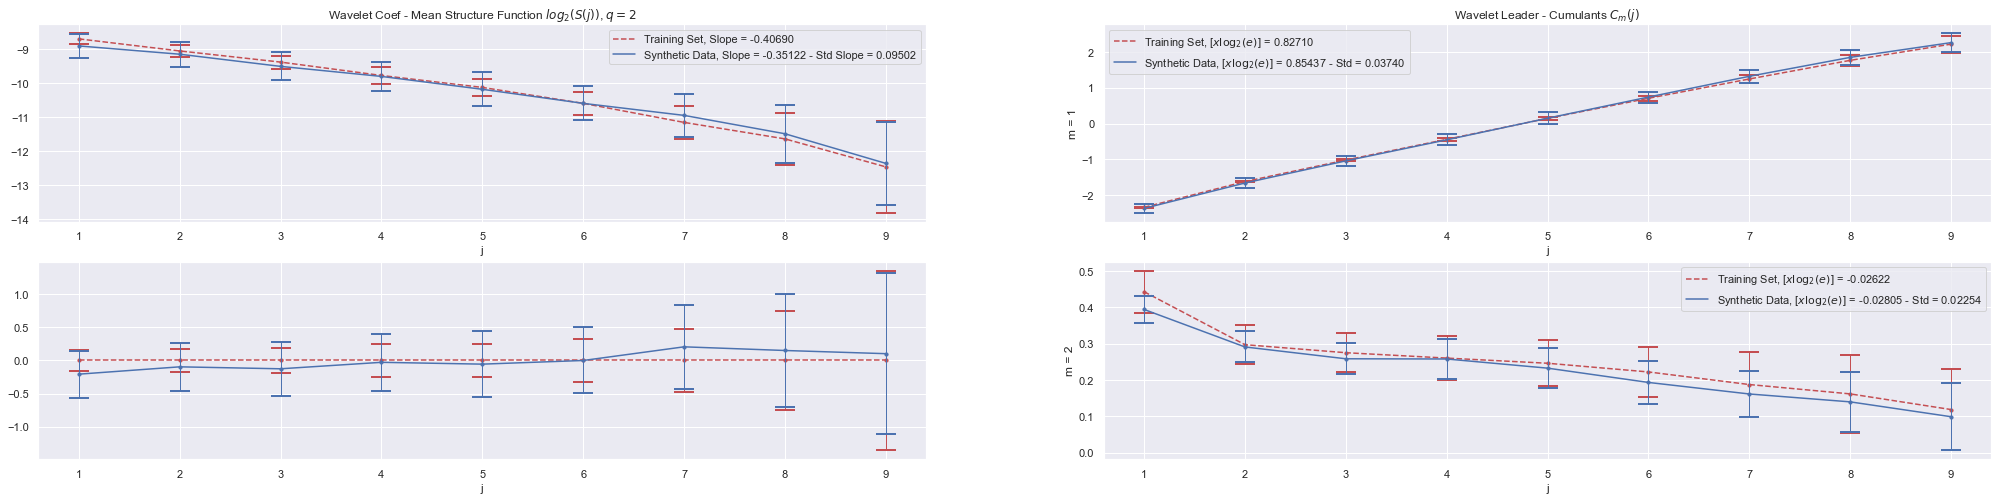

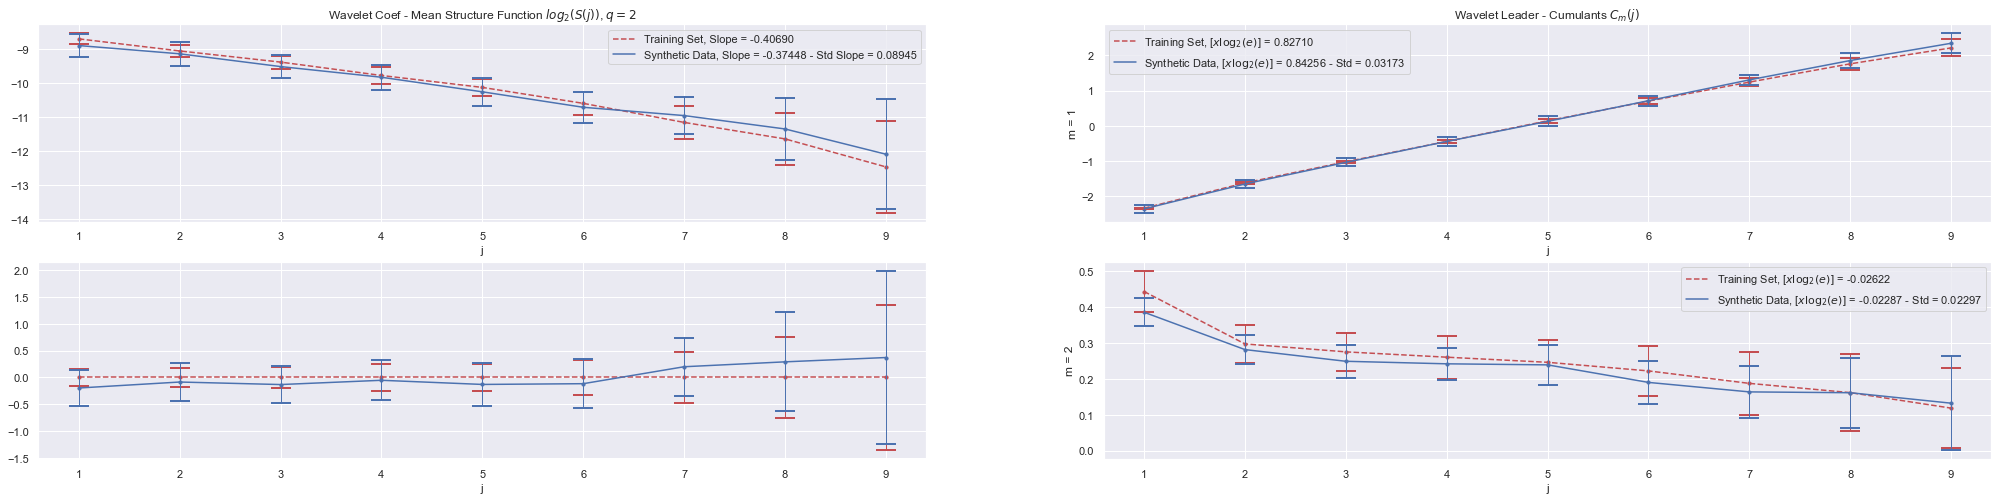

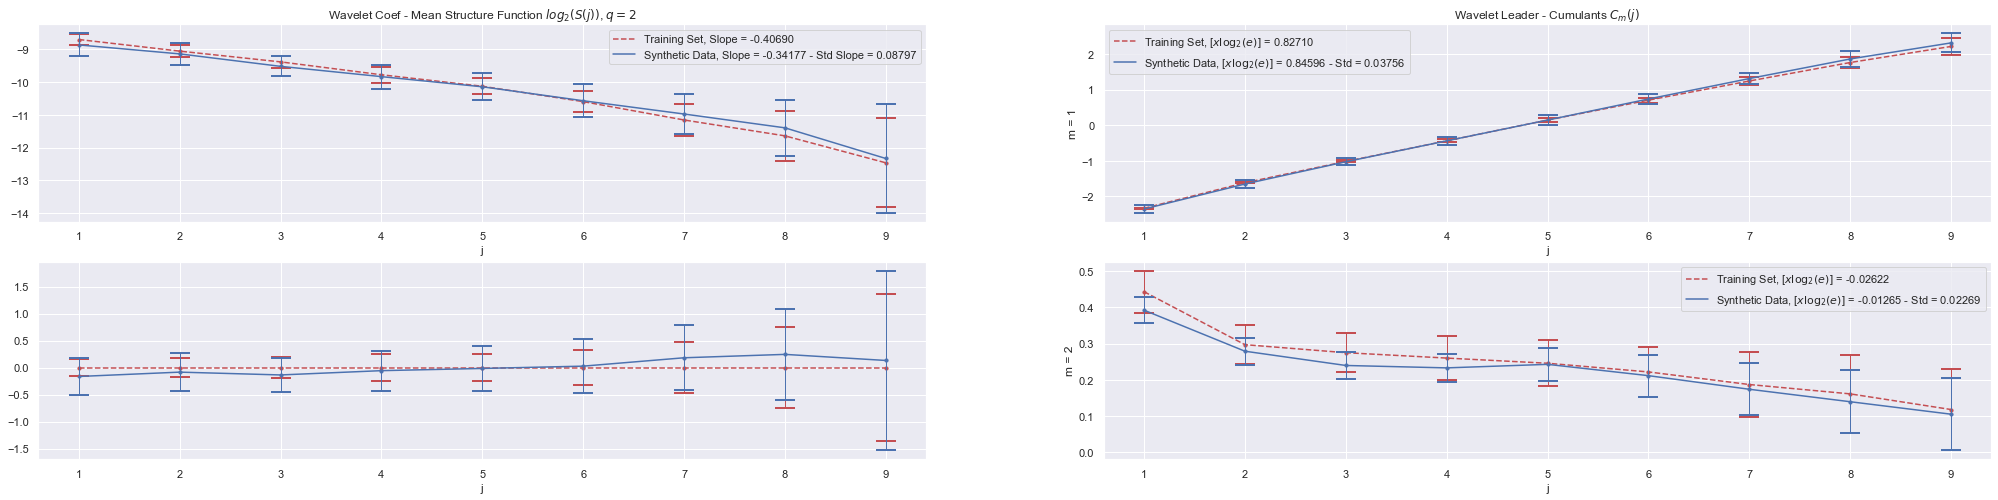

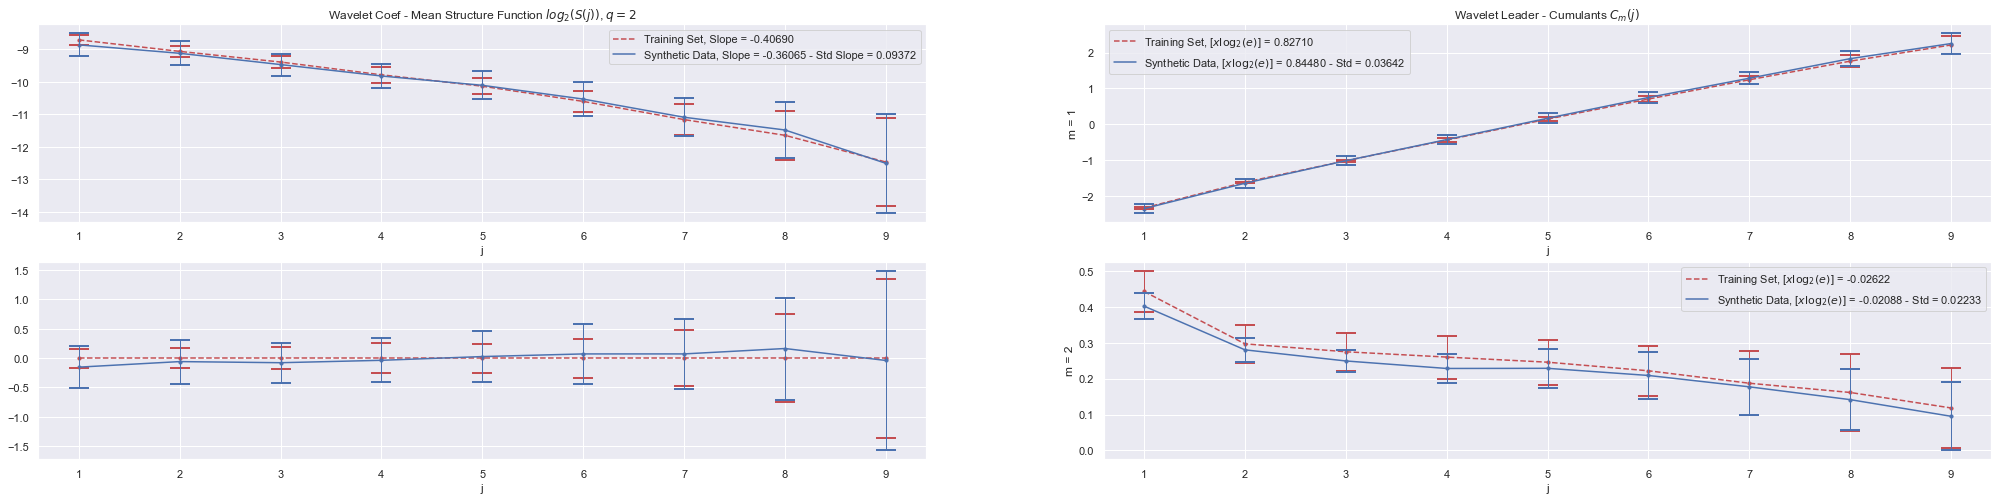

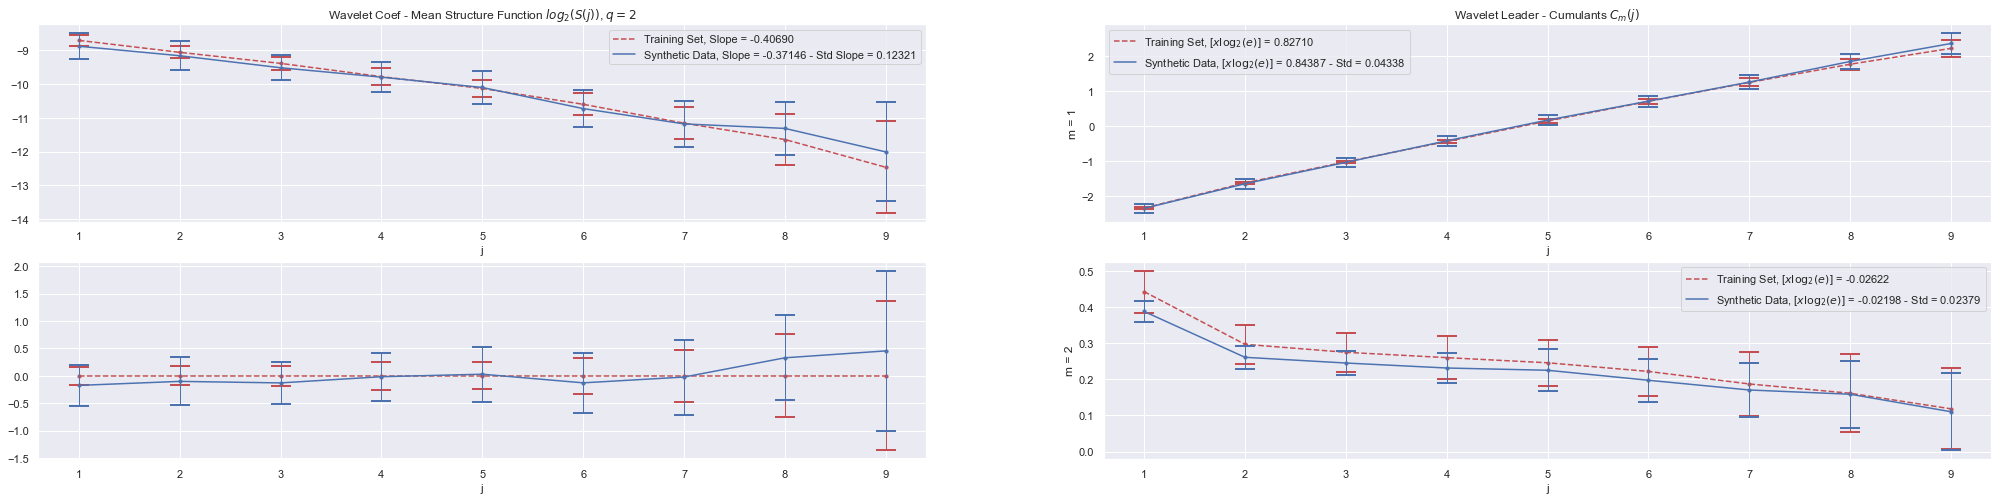

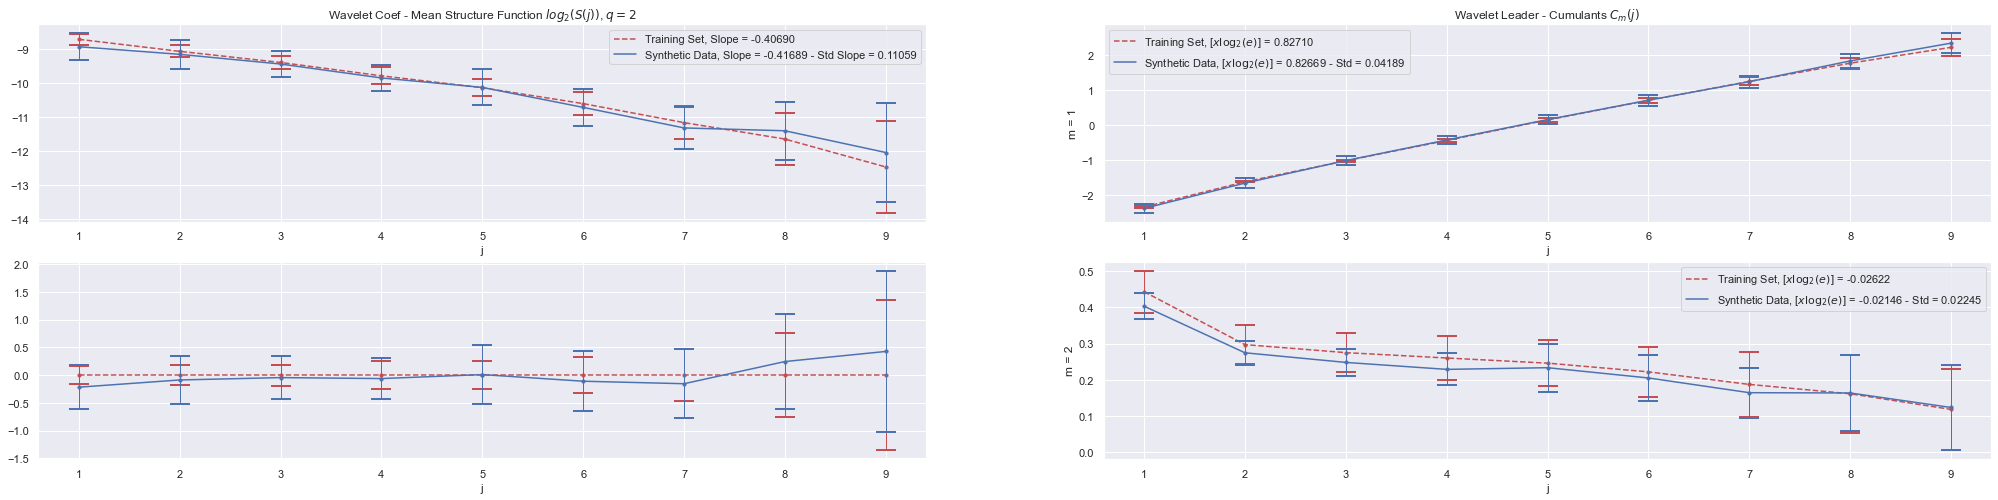

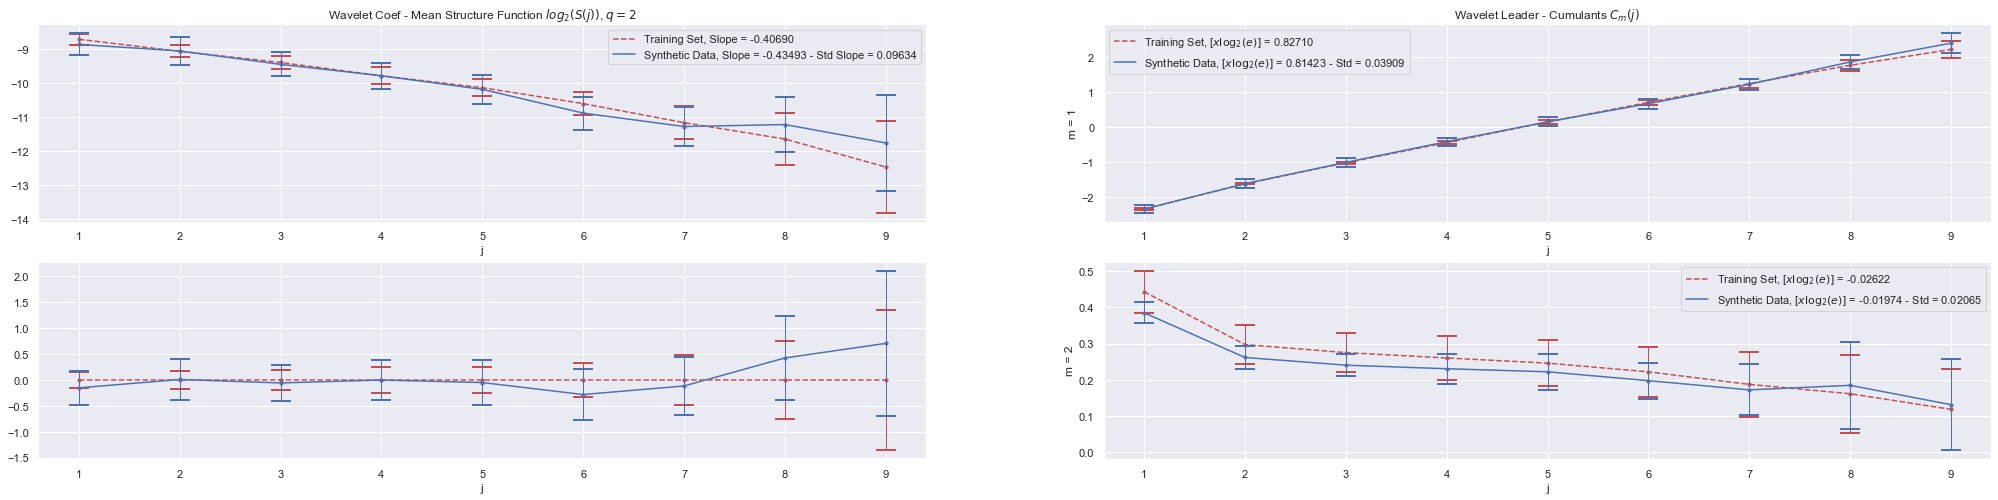

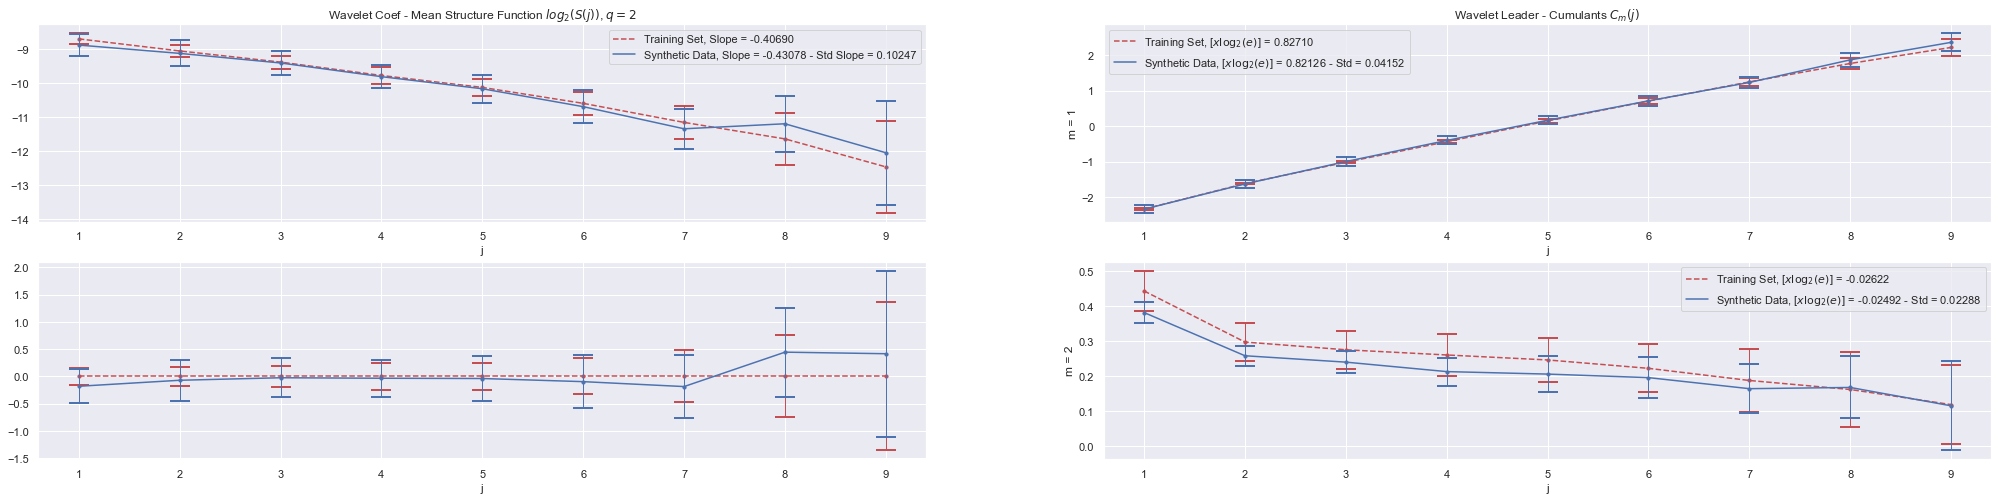

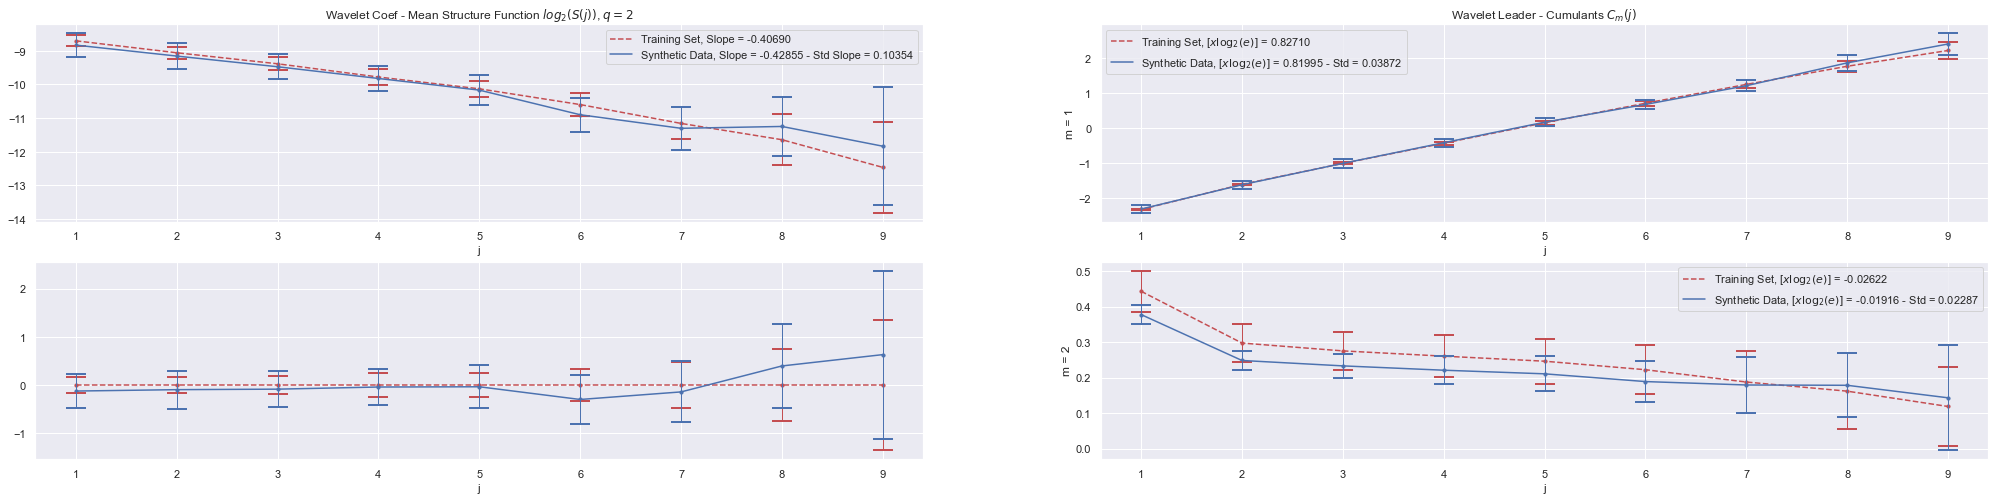

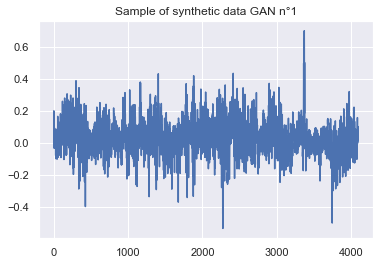

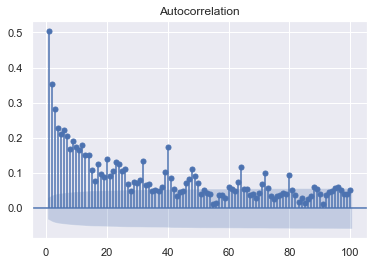

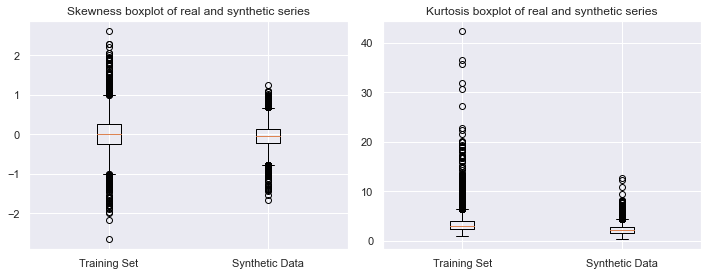

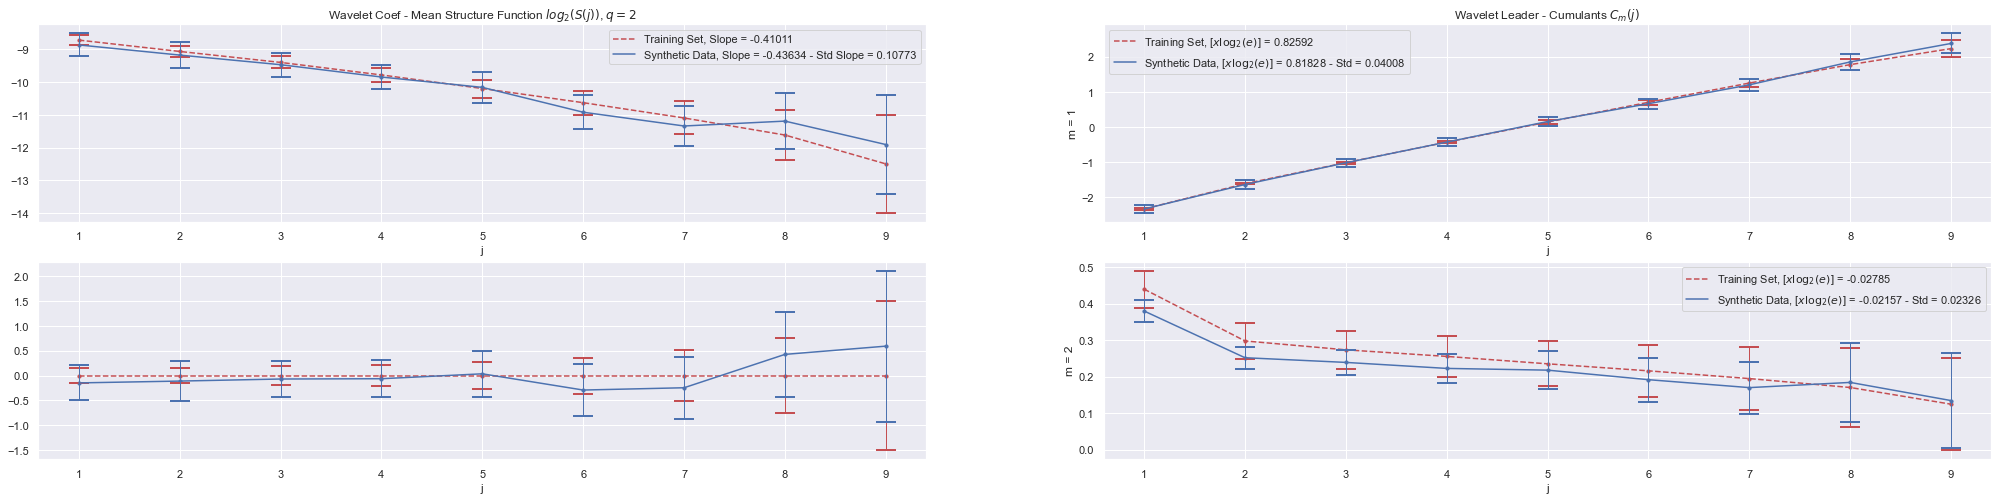

.....
New Training
.....


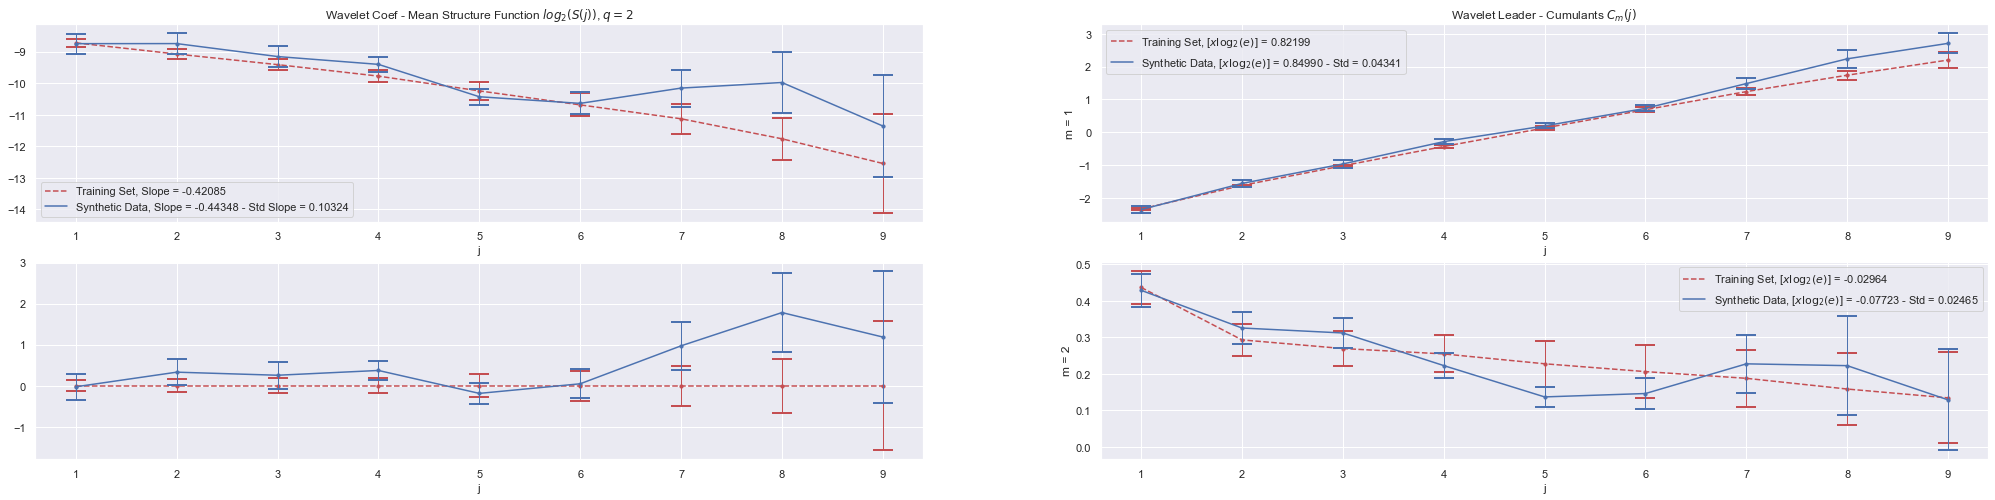

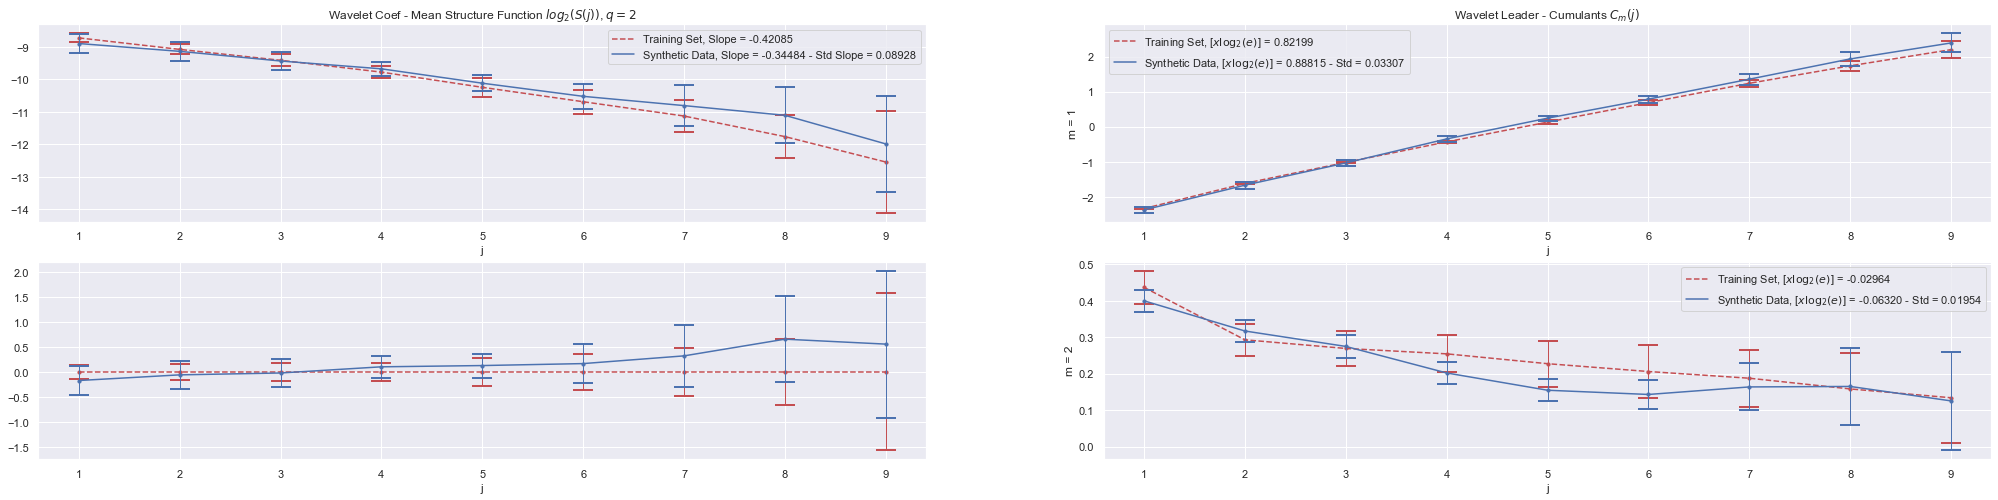

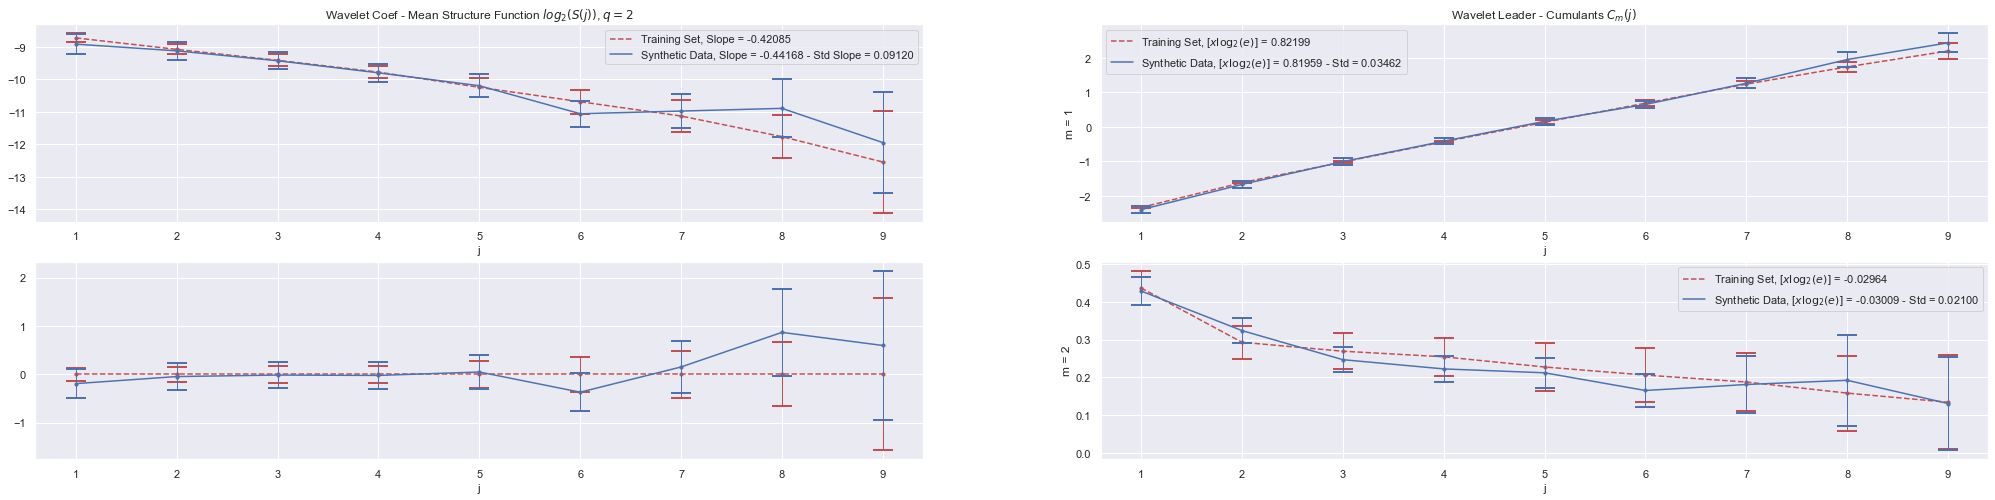

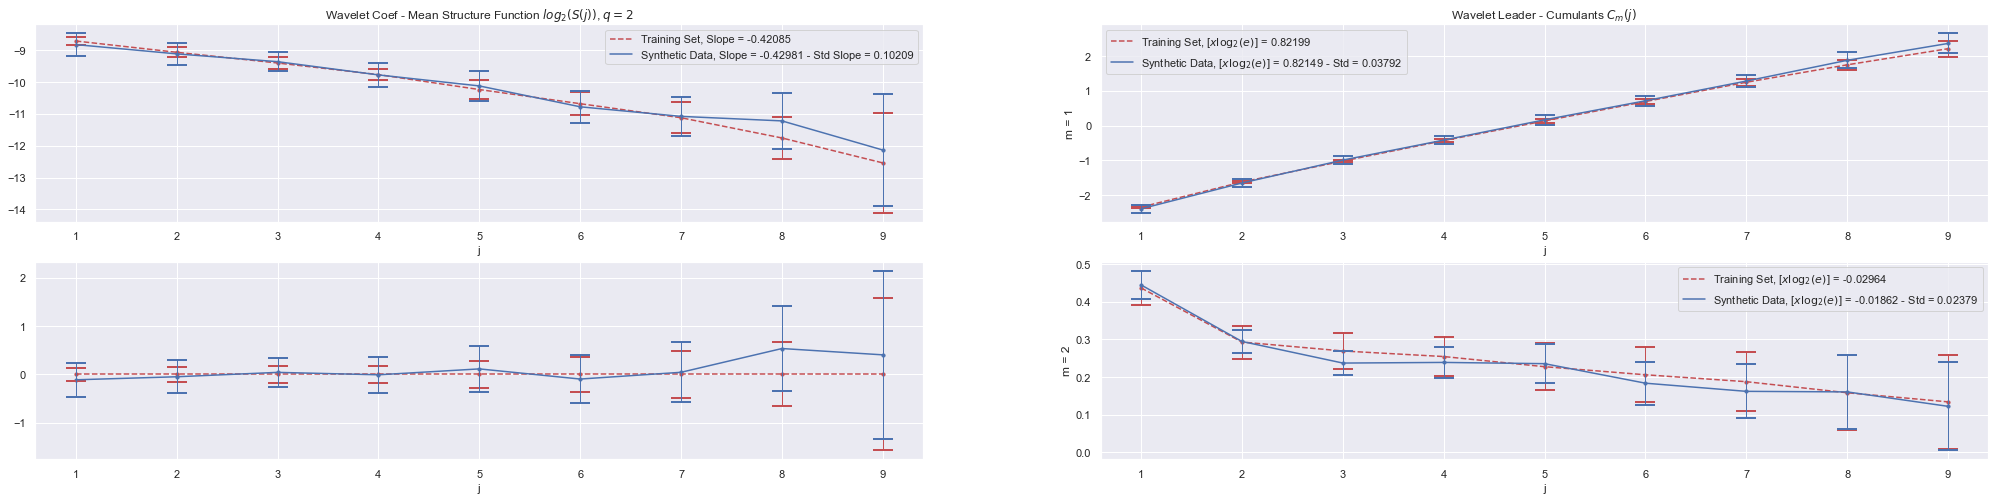

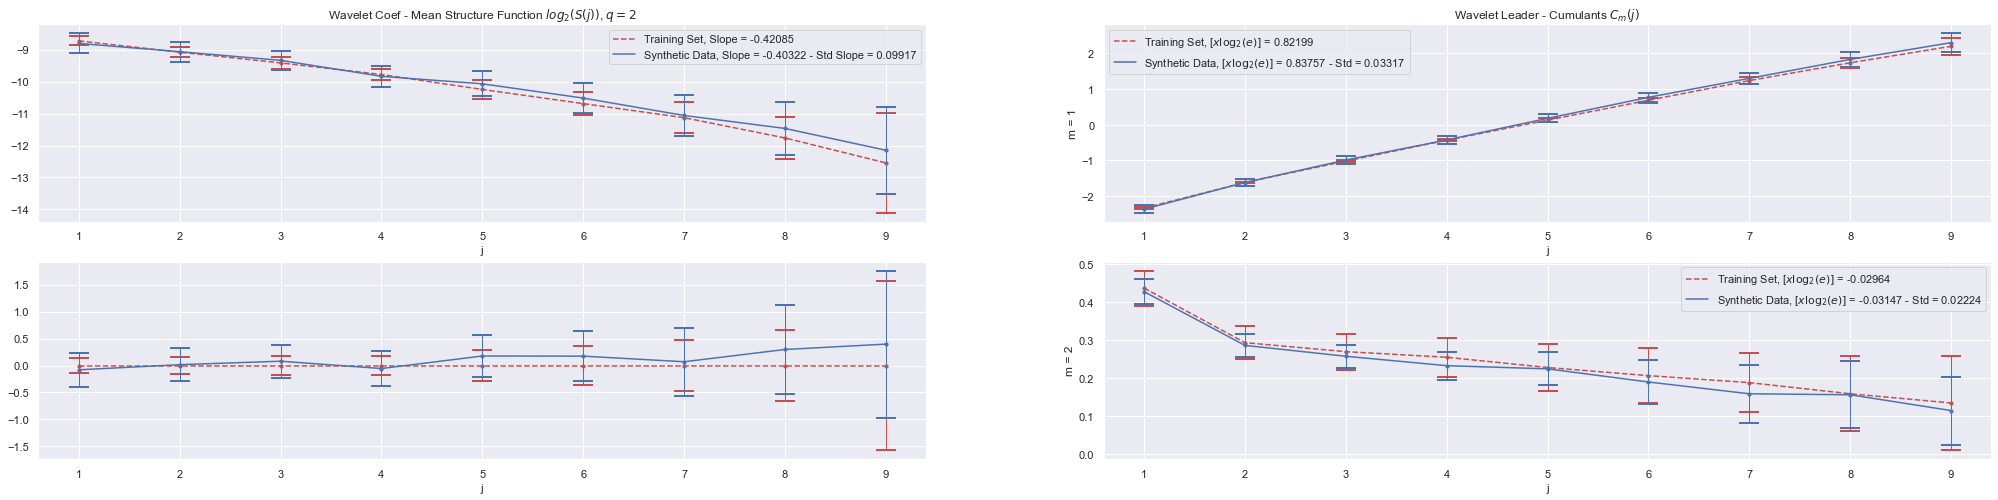

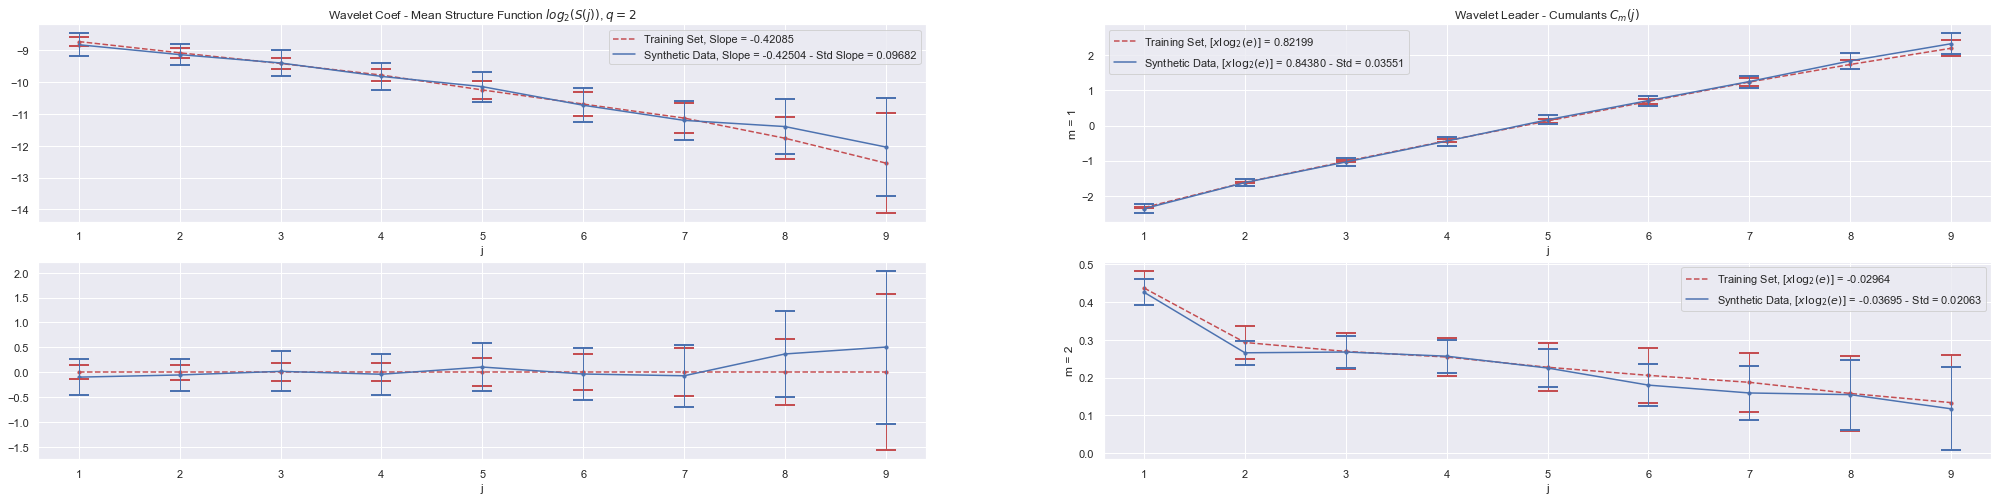

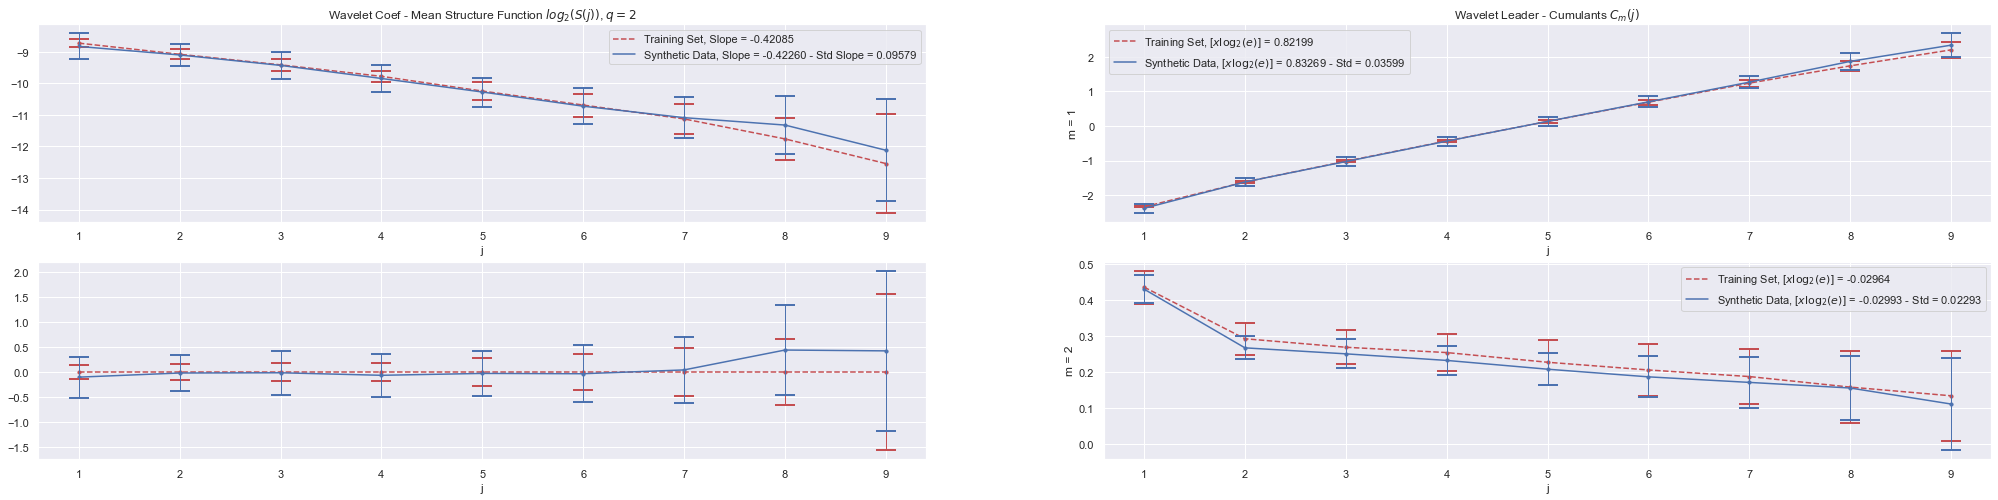

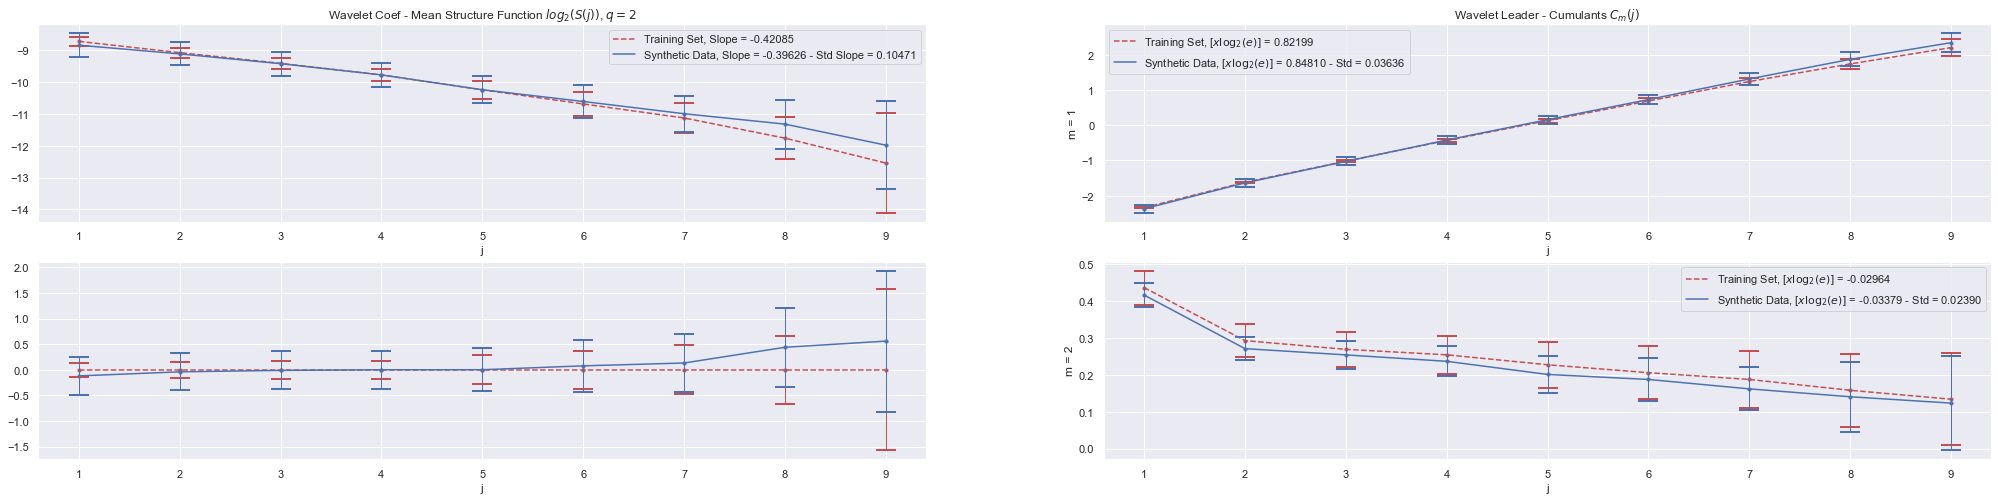

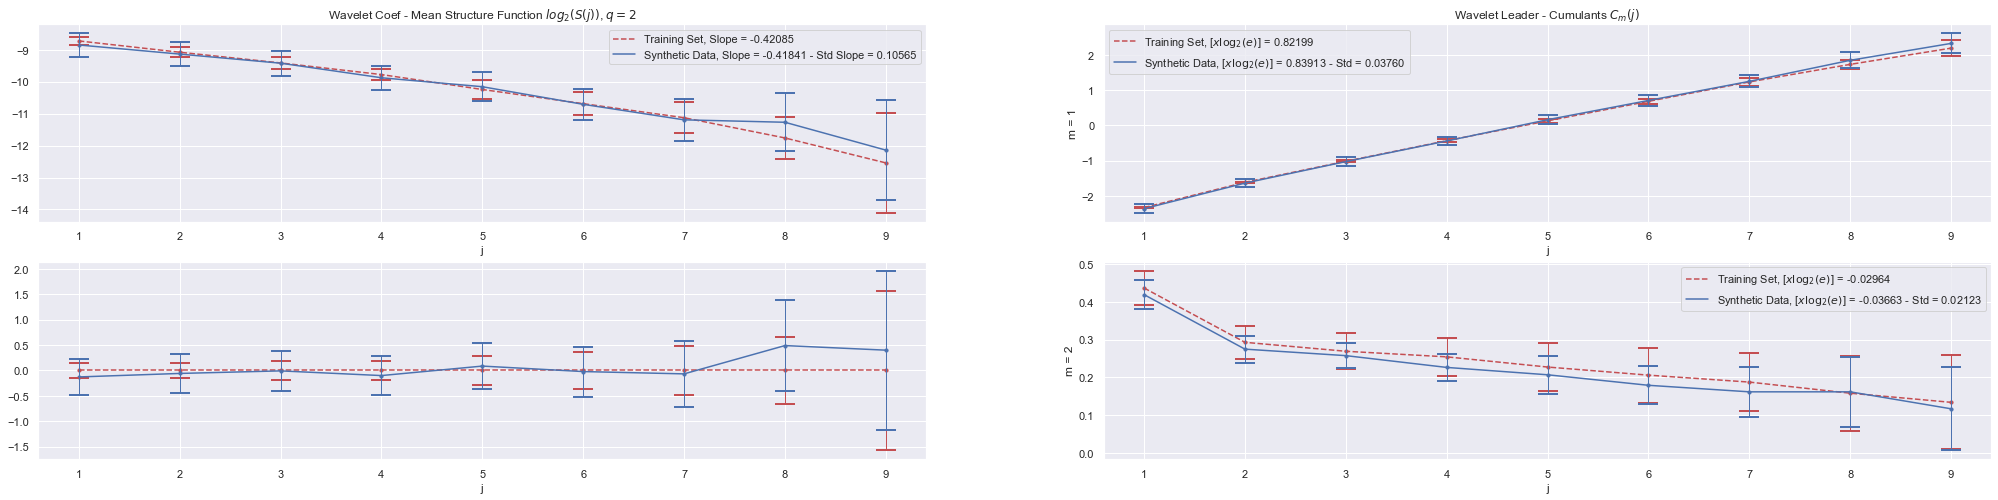

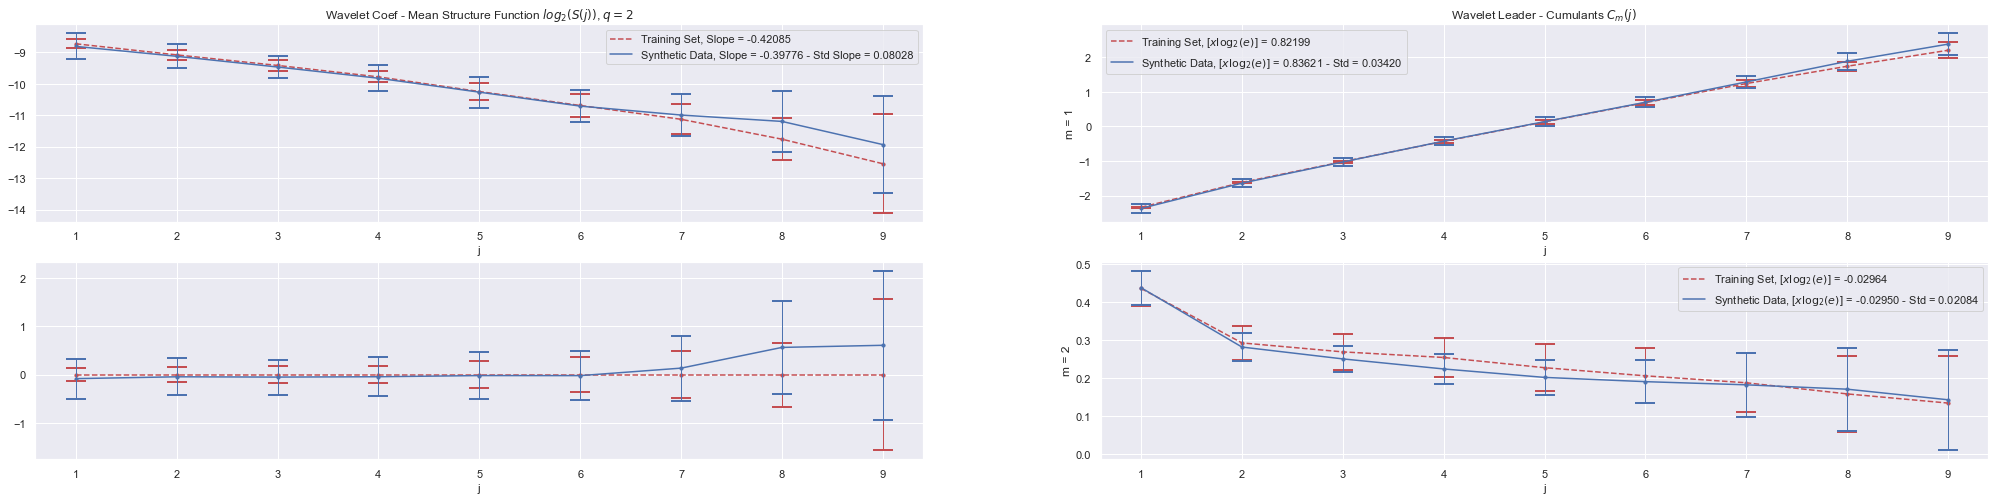

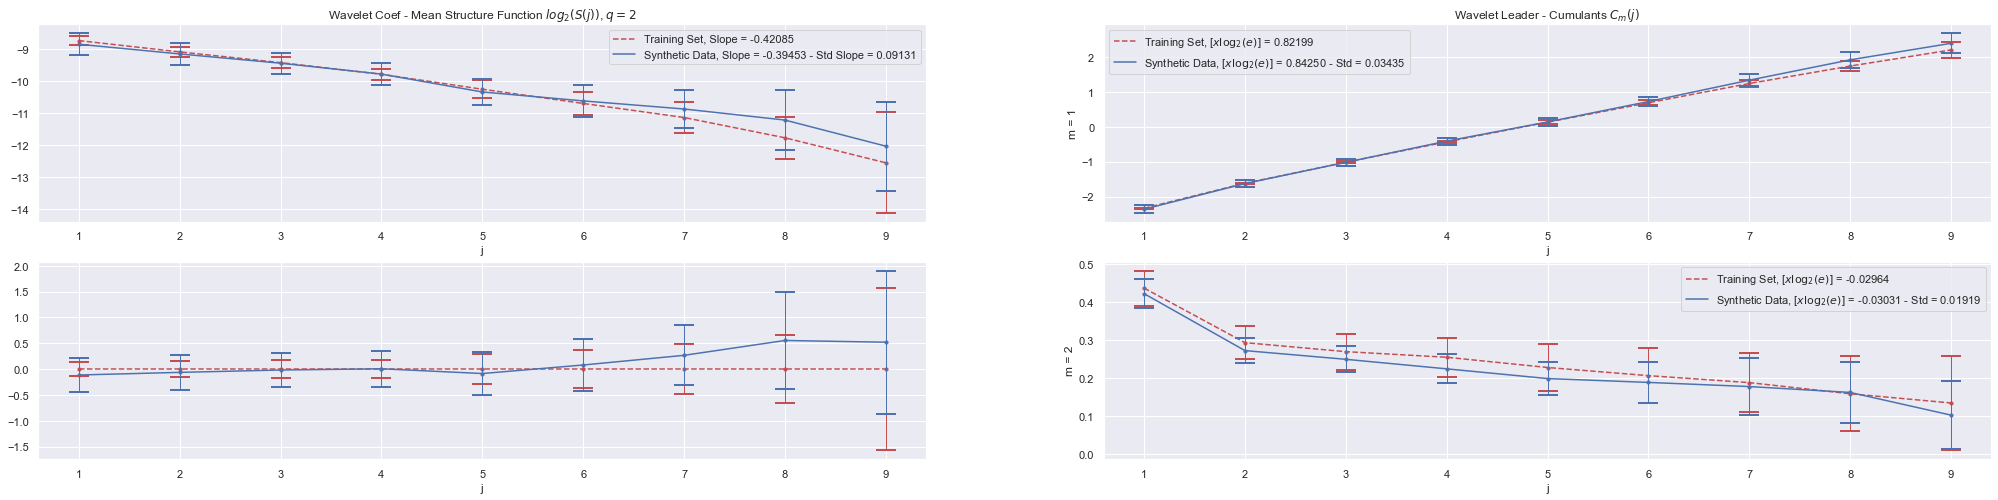

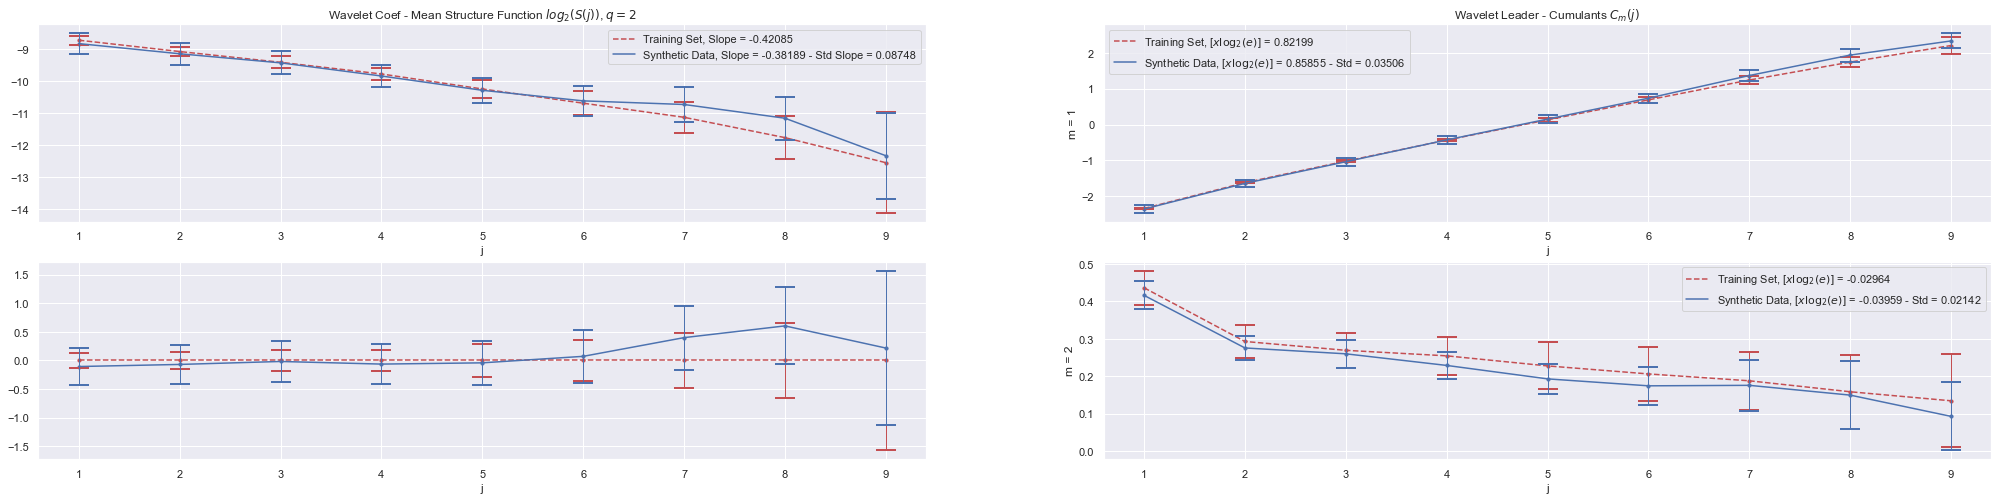

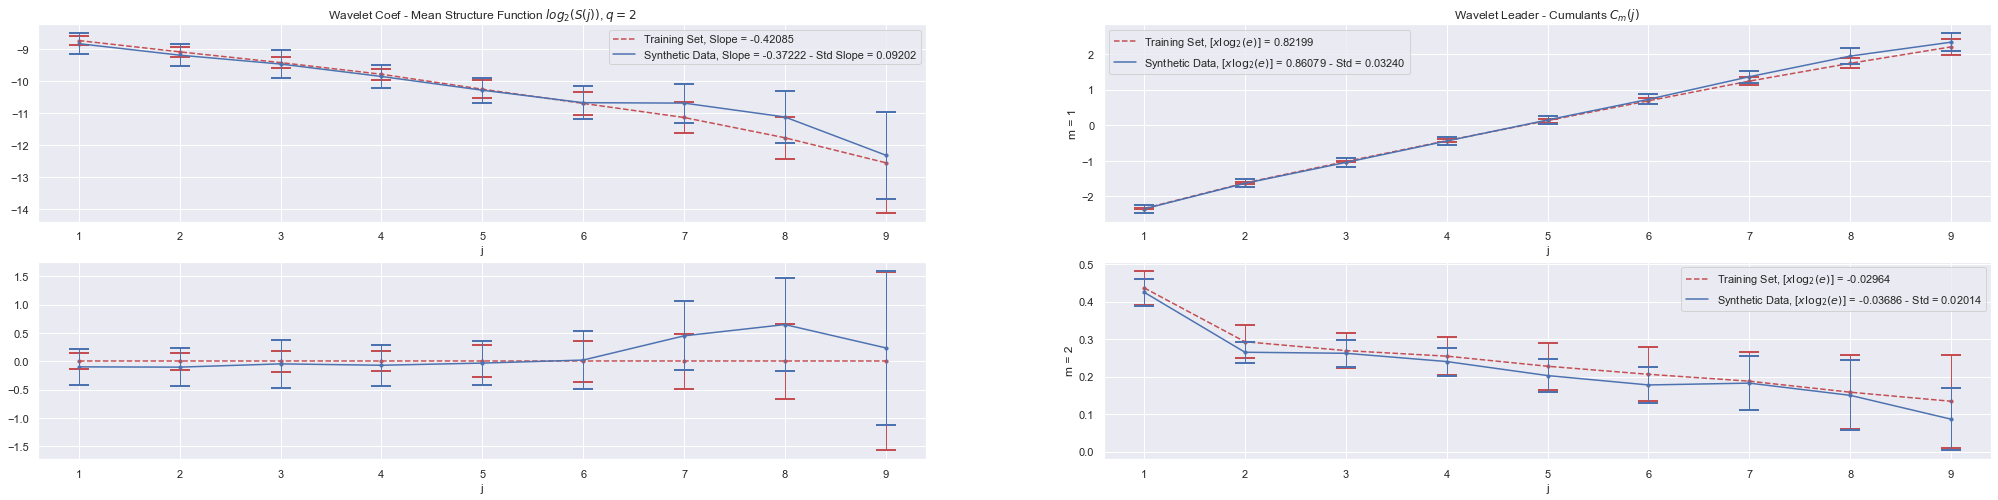

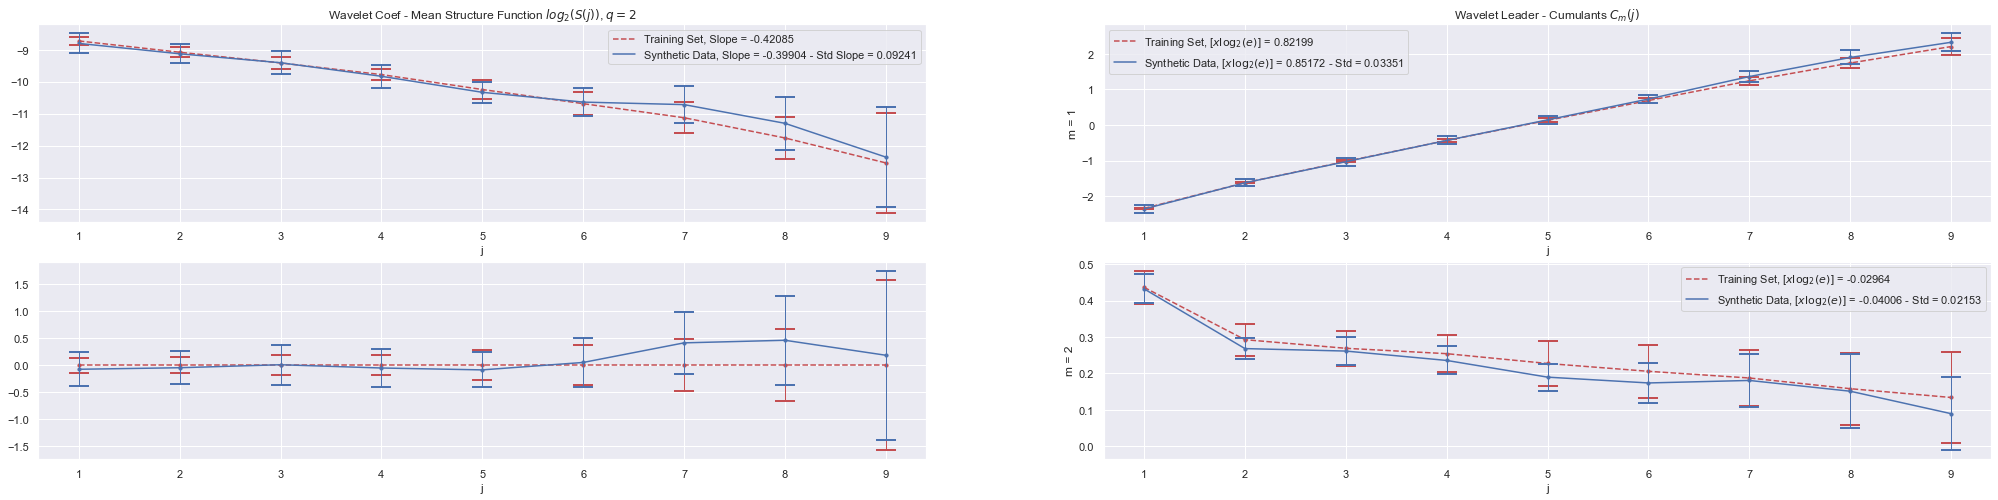

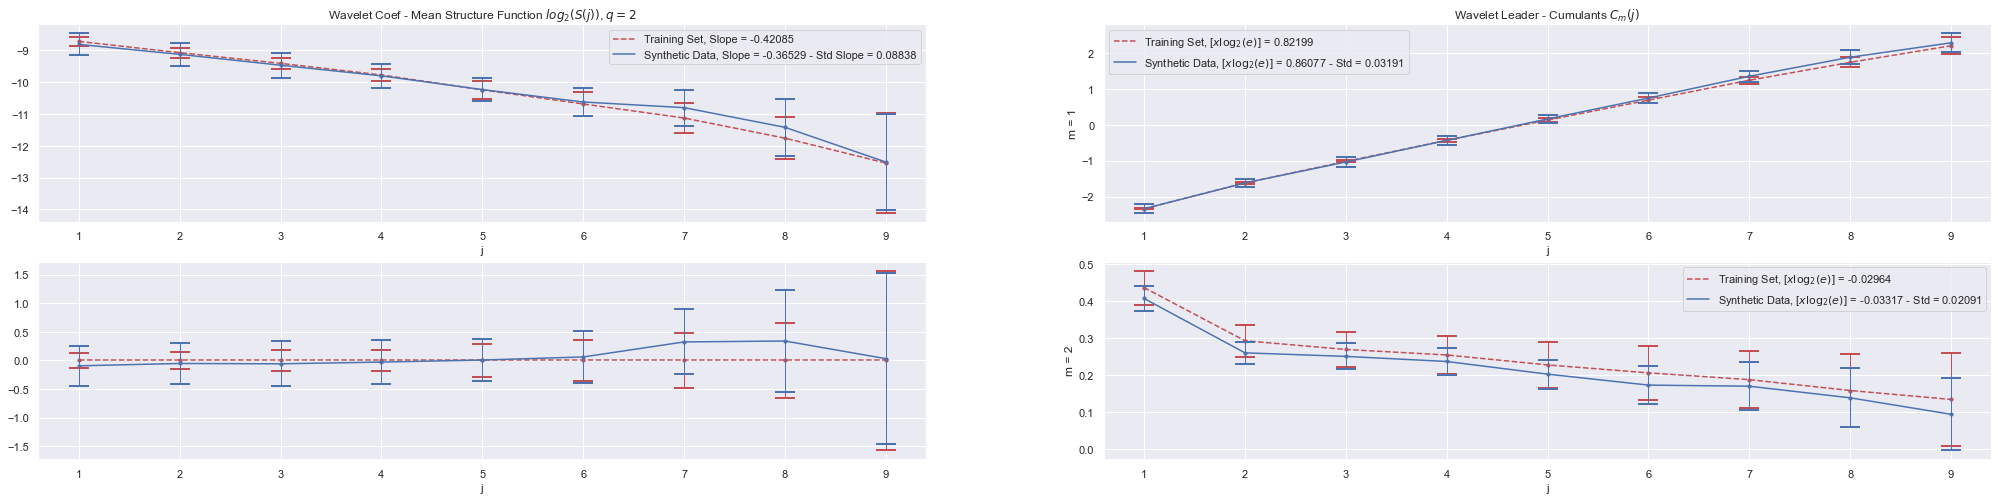

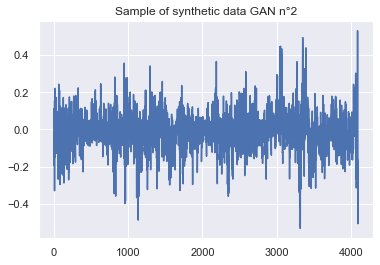

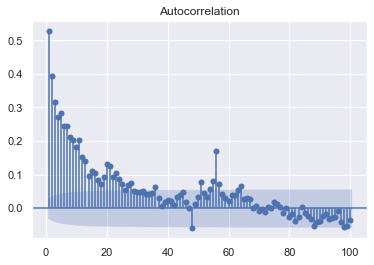

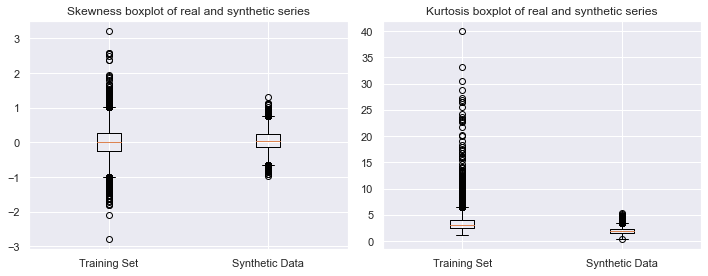

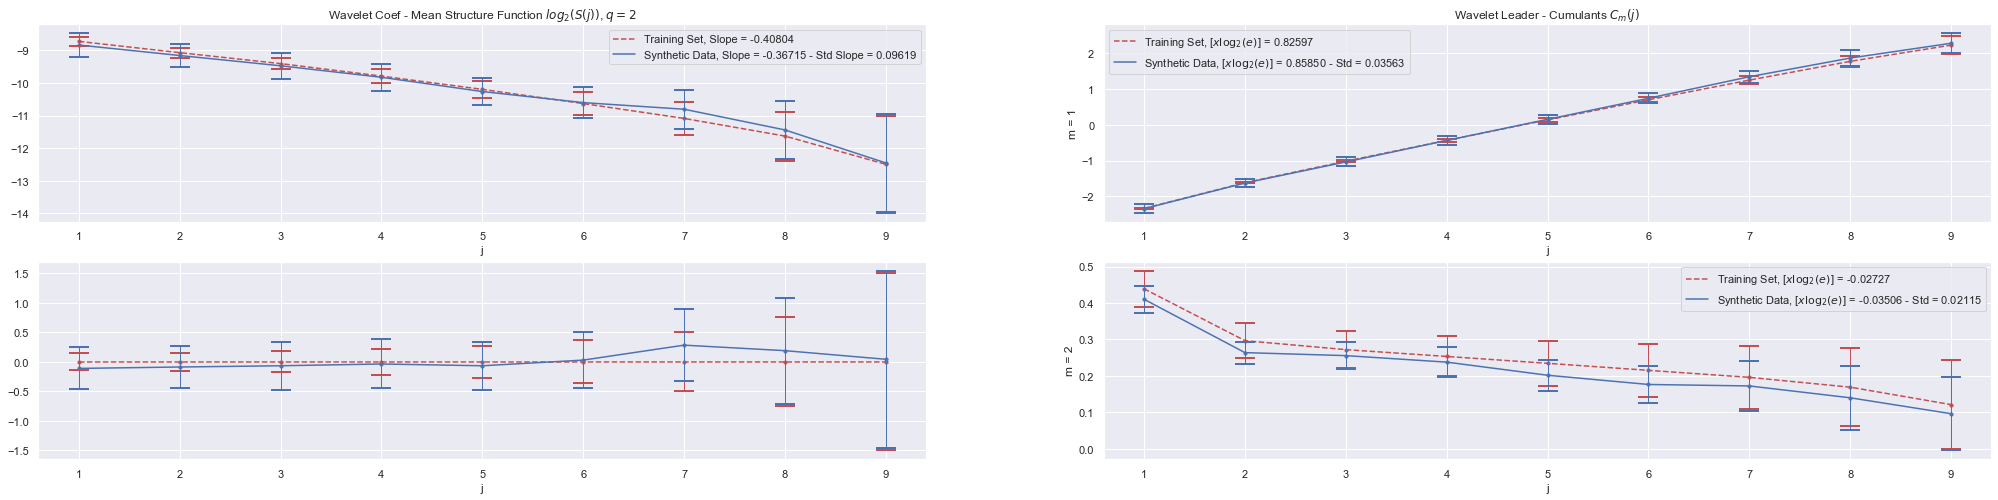

.....
New Training
.....


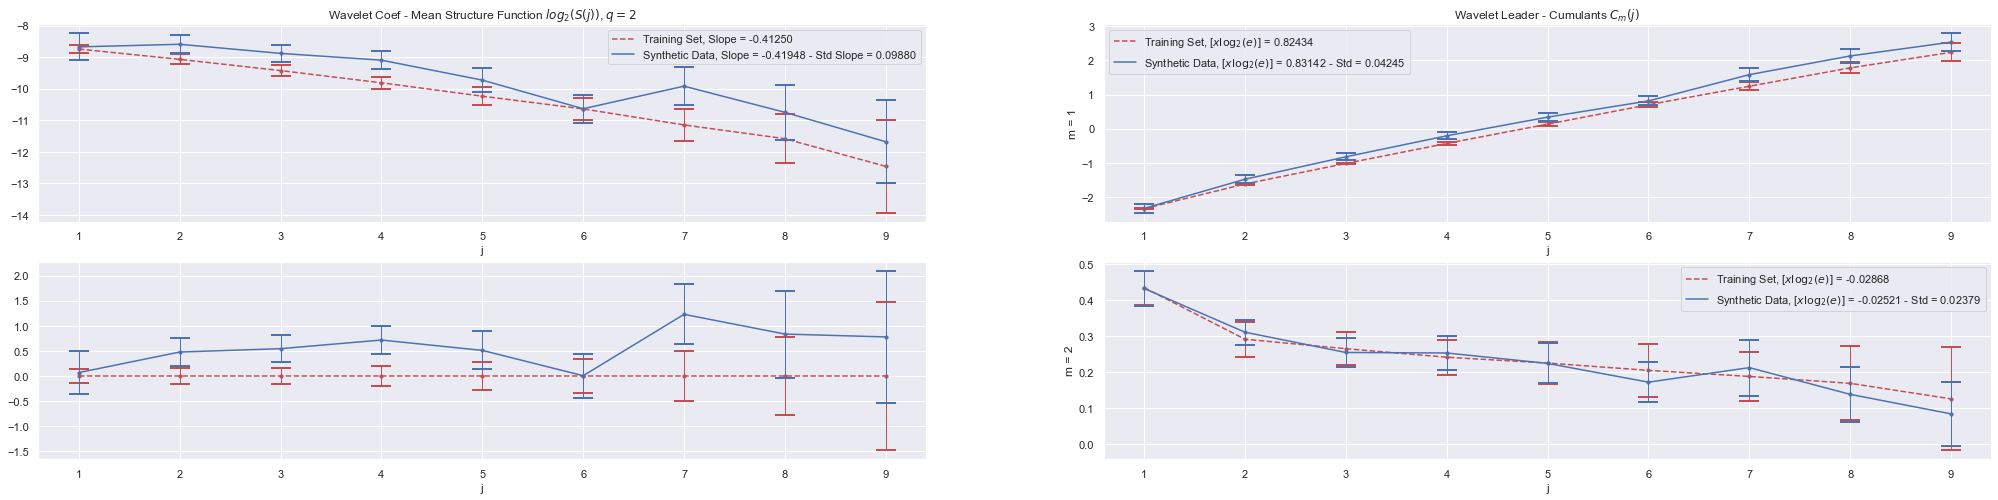

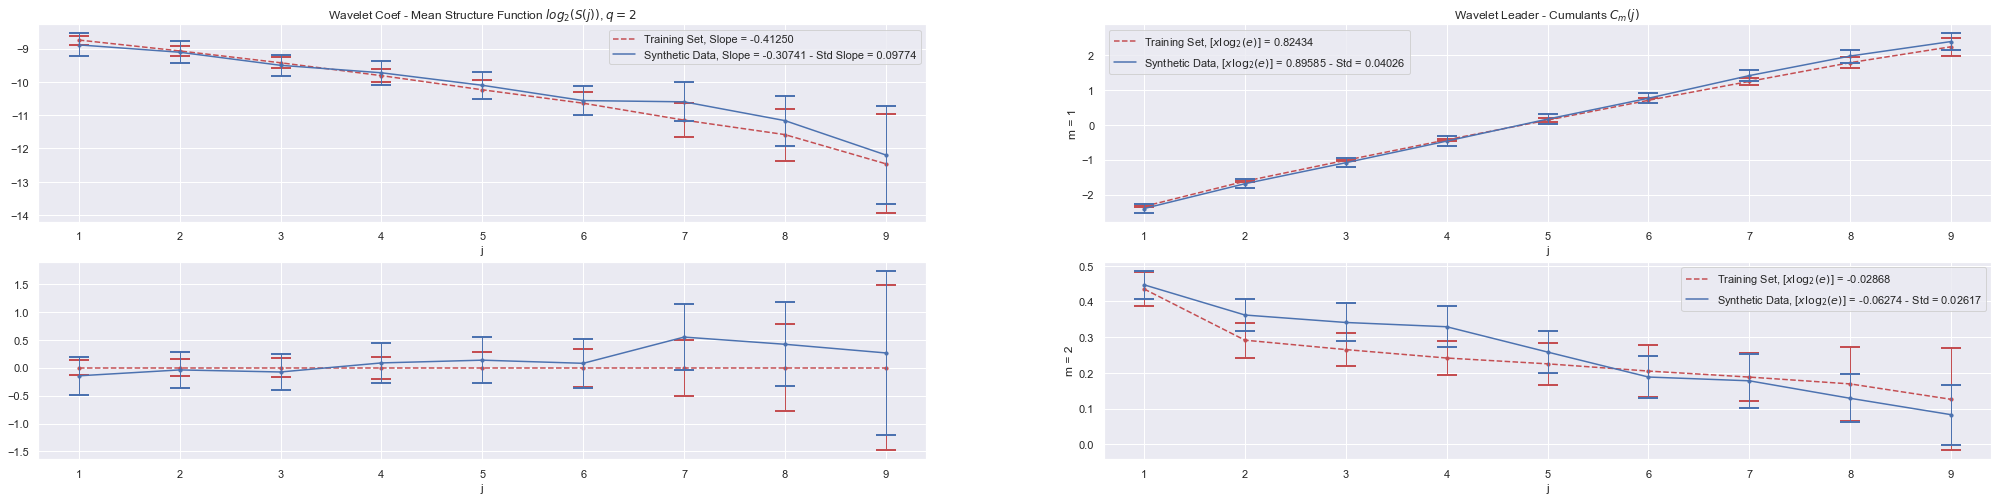

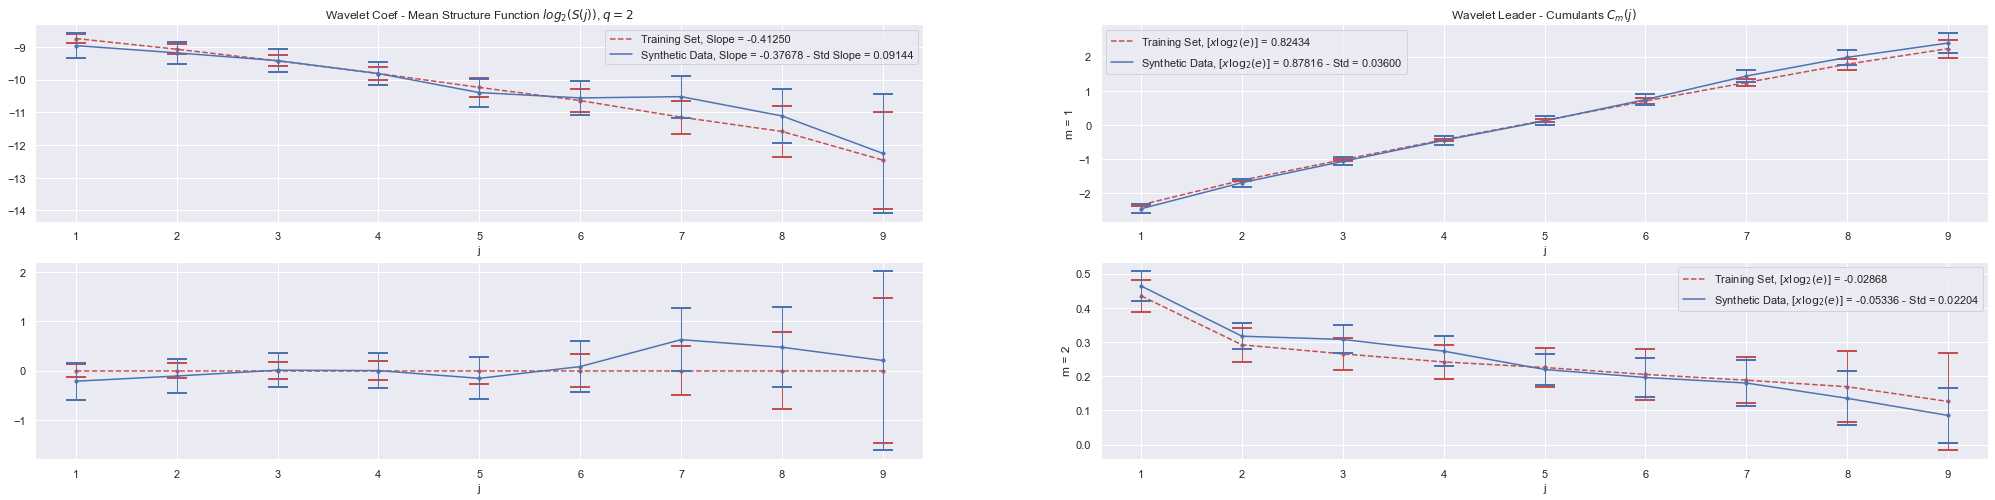

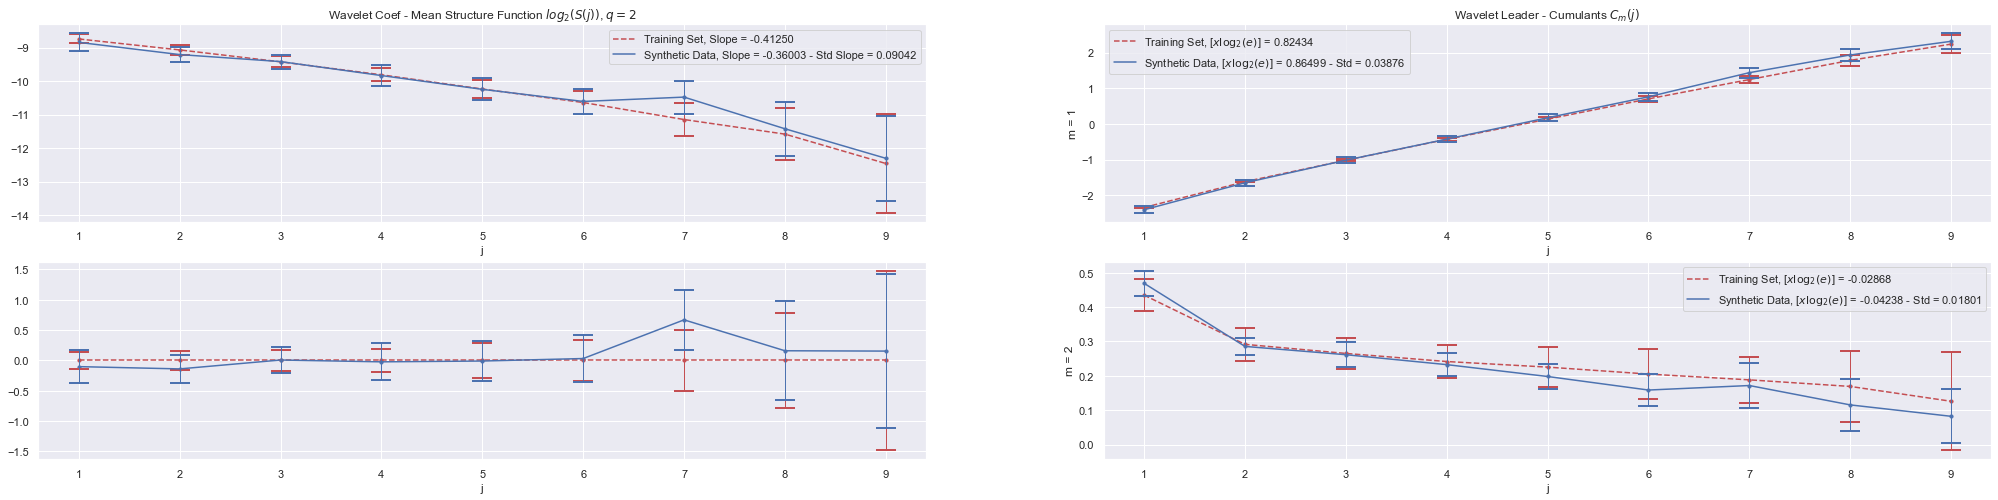

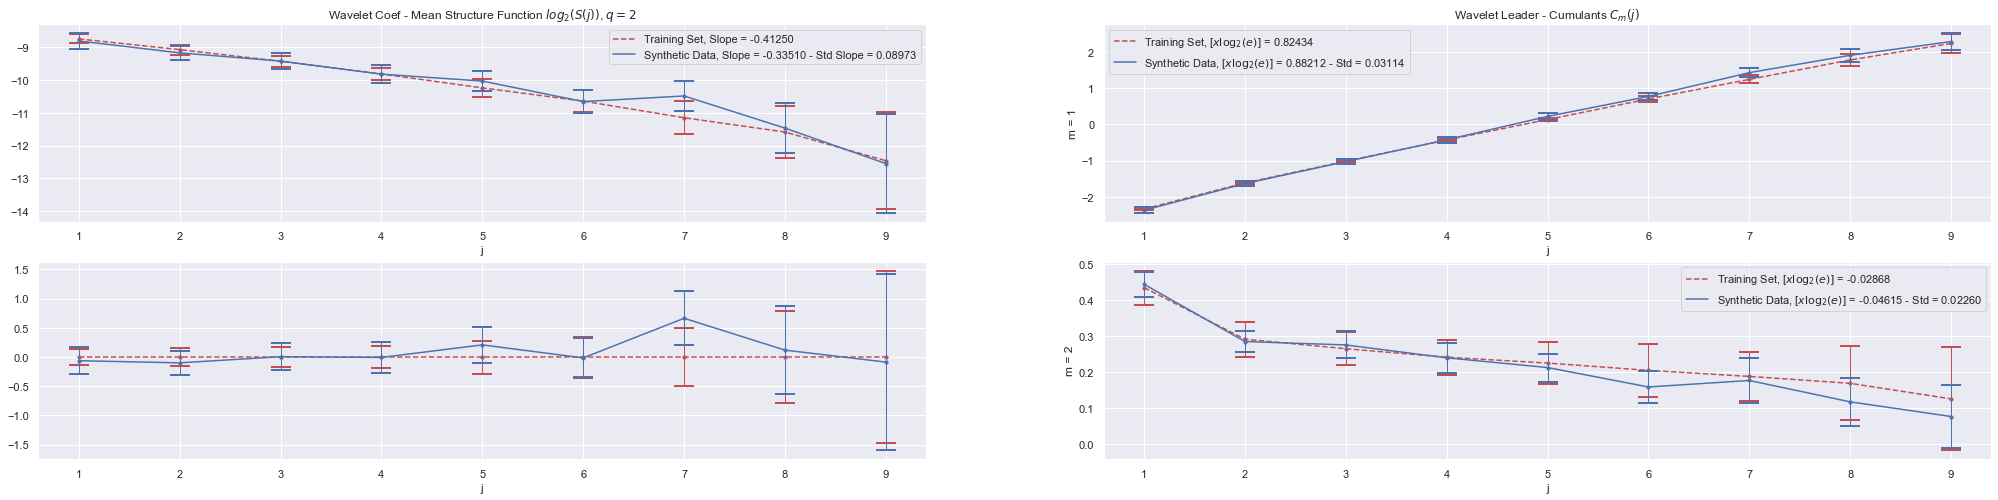

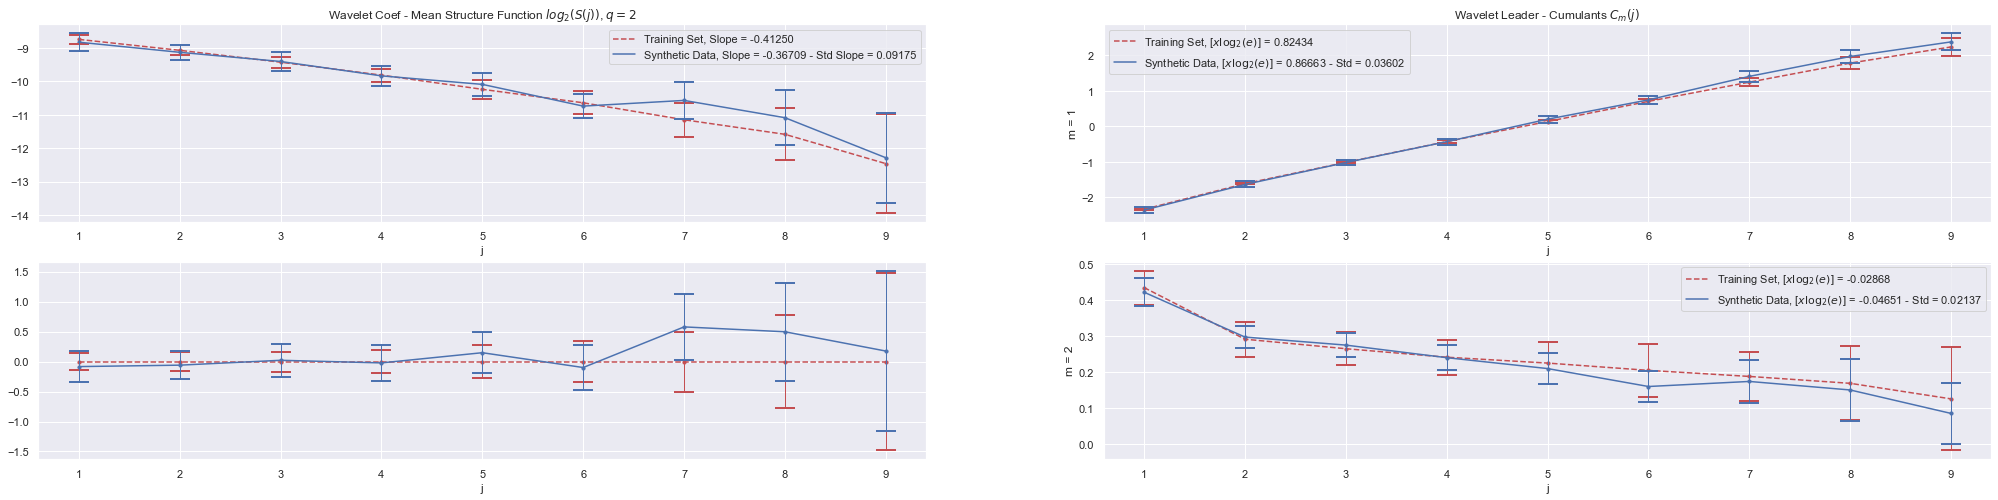

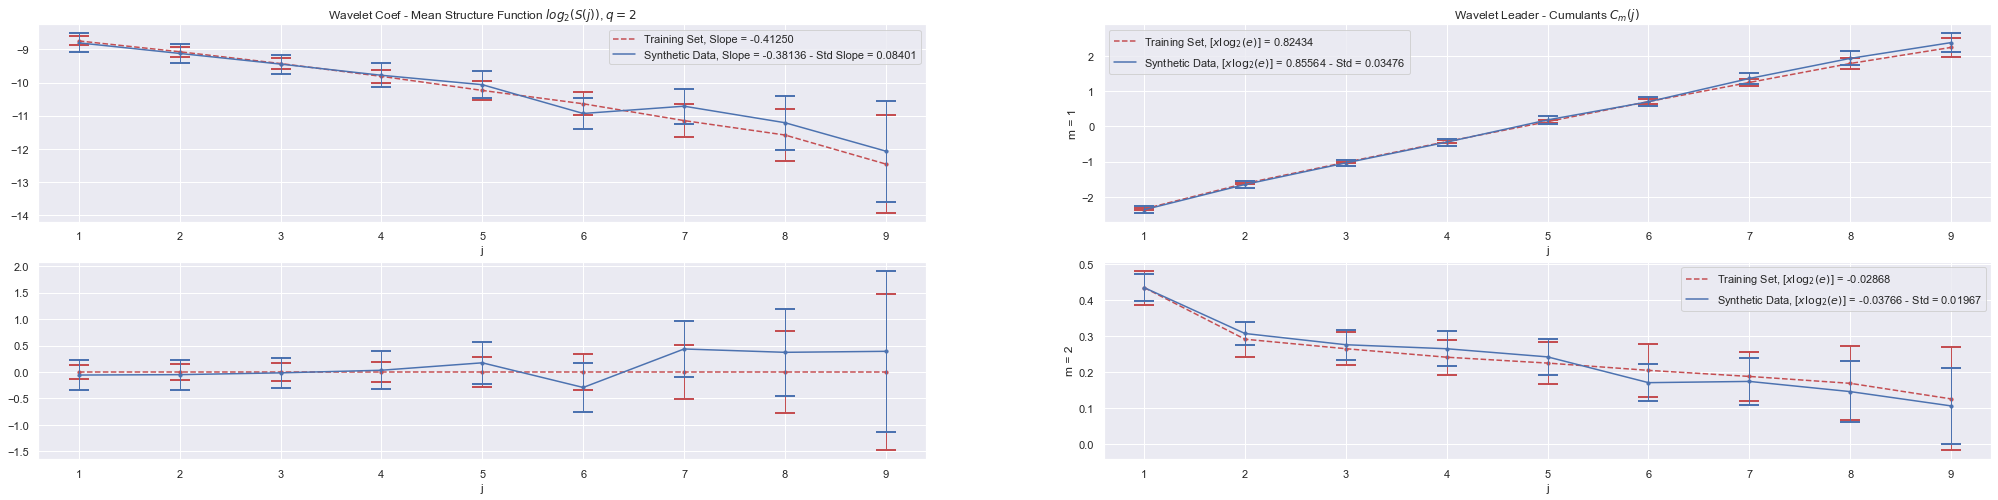

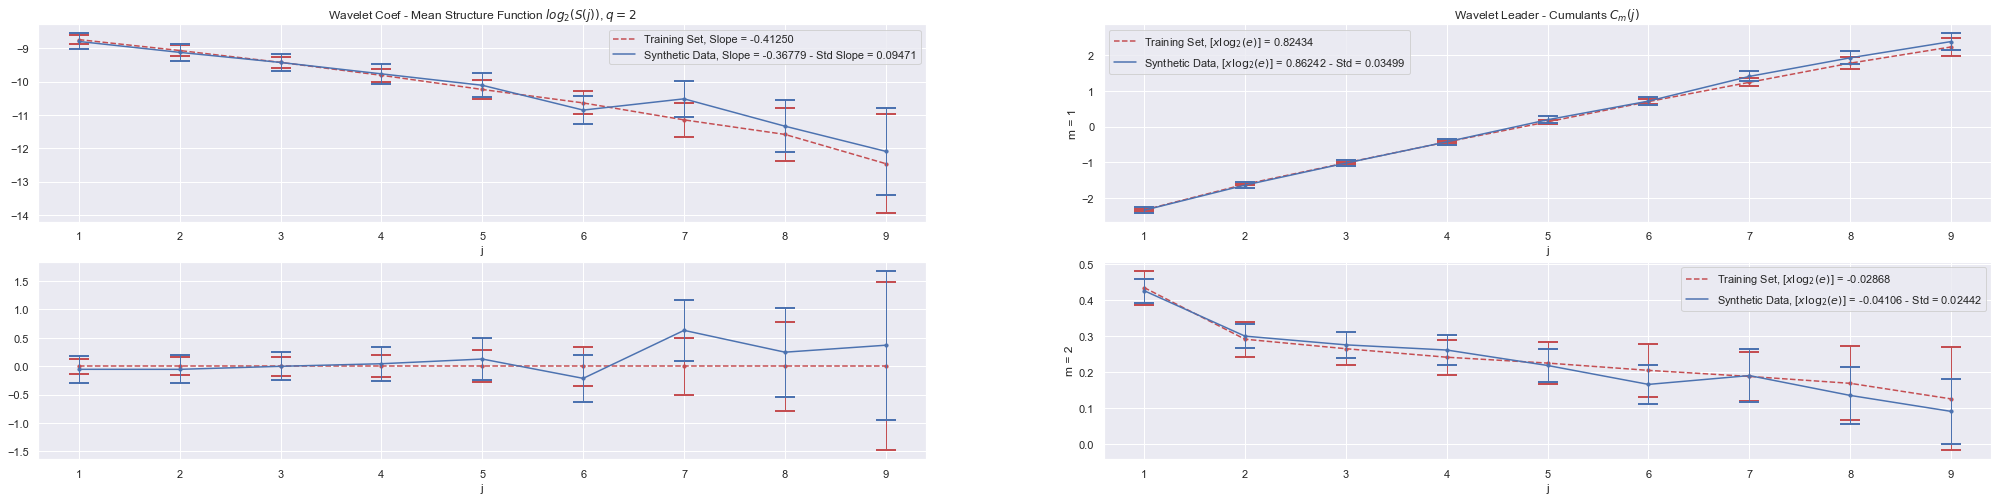

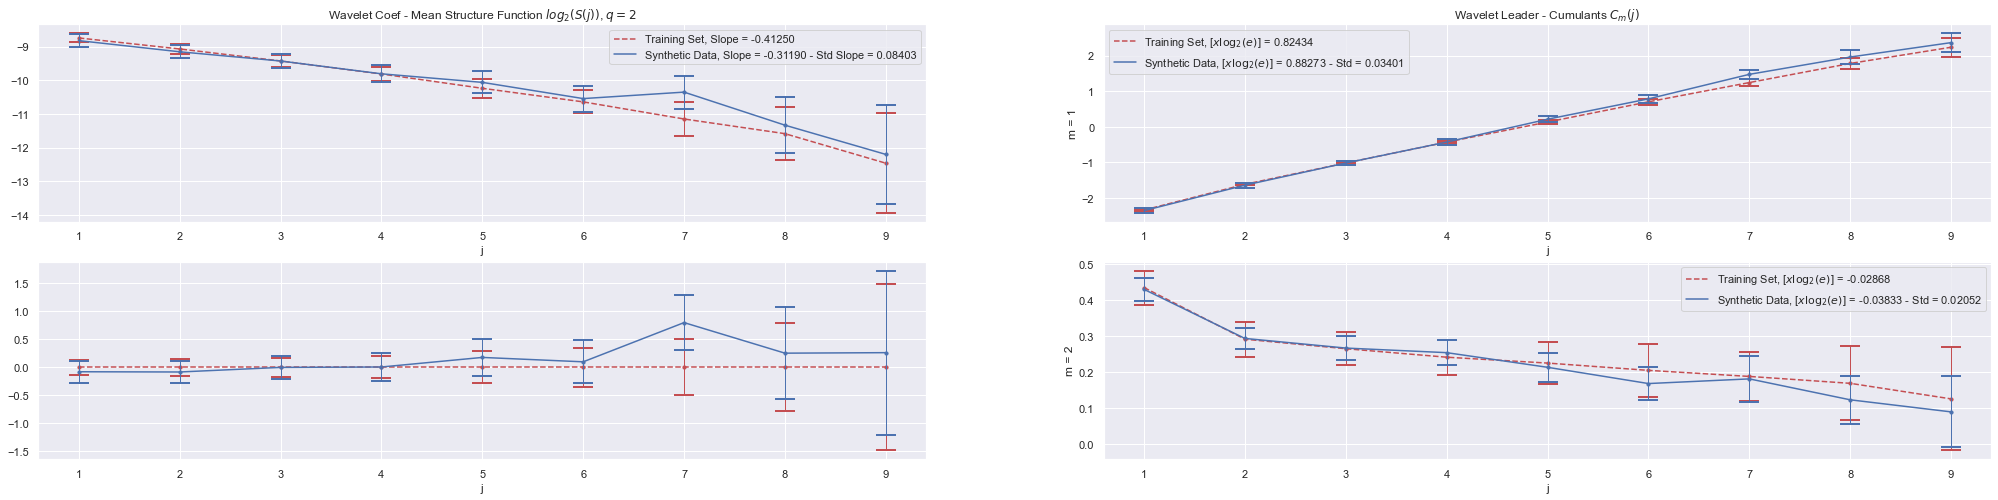

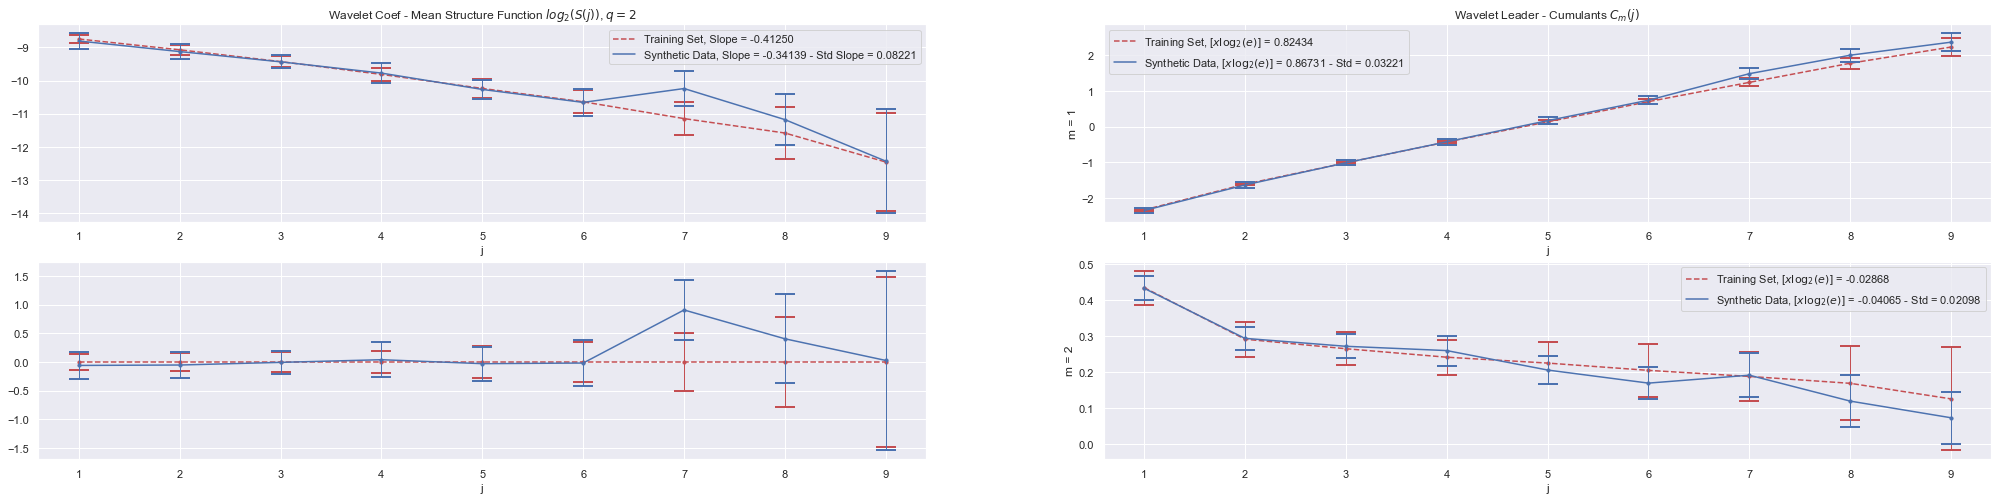

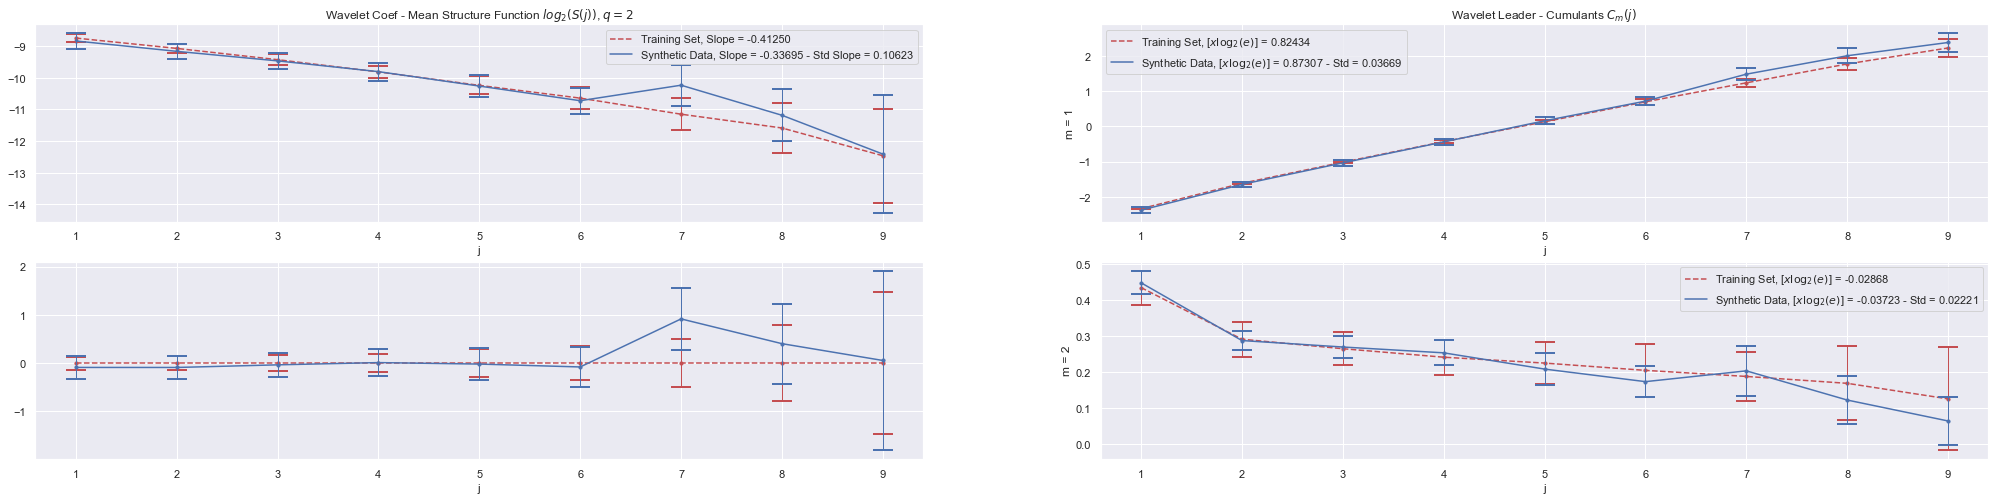

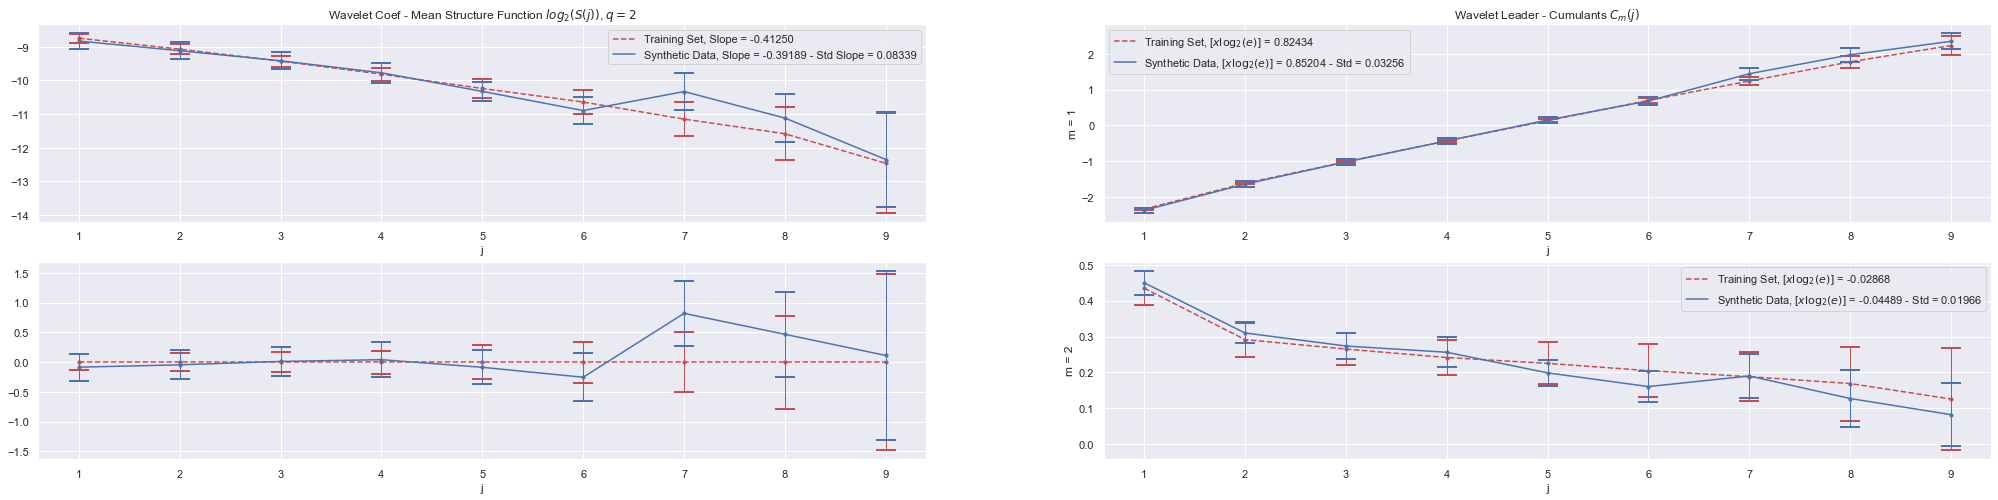

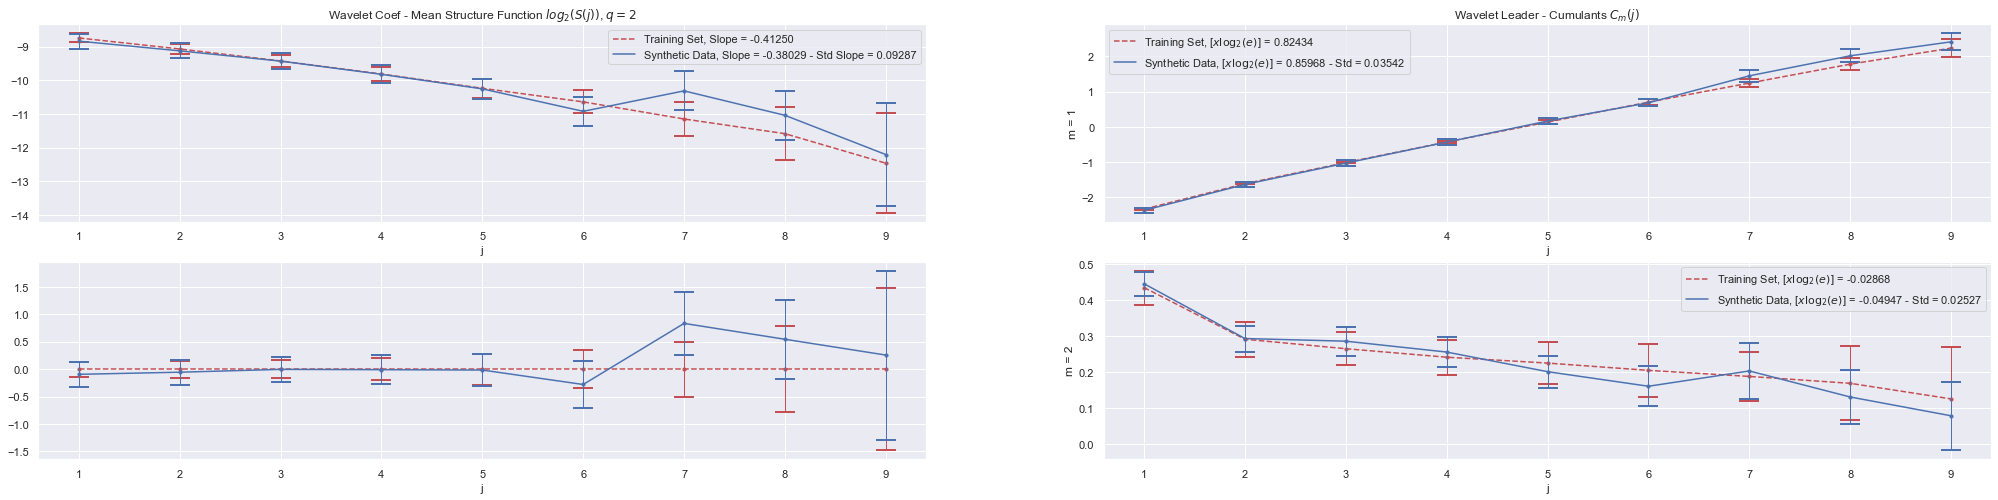

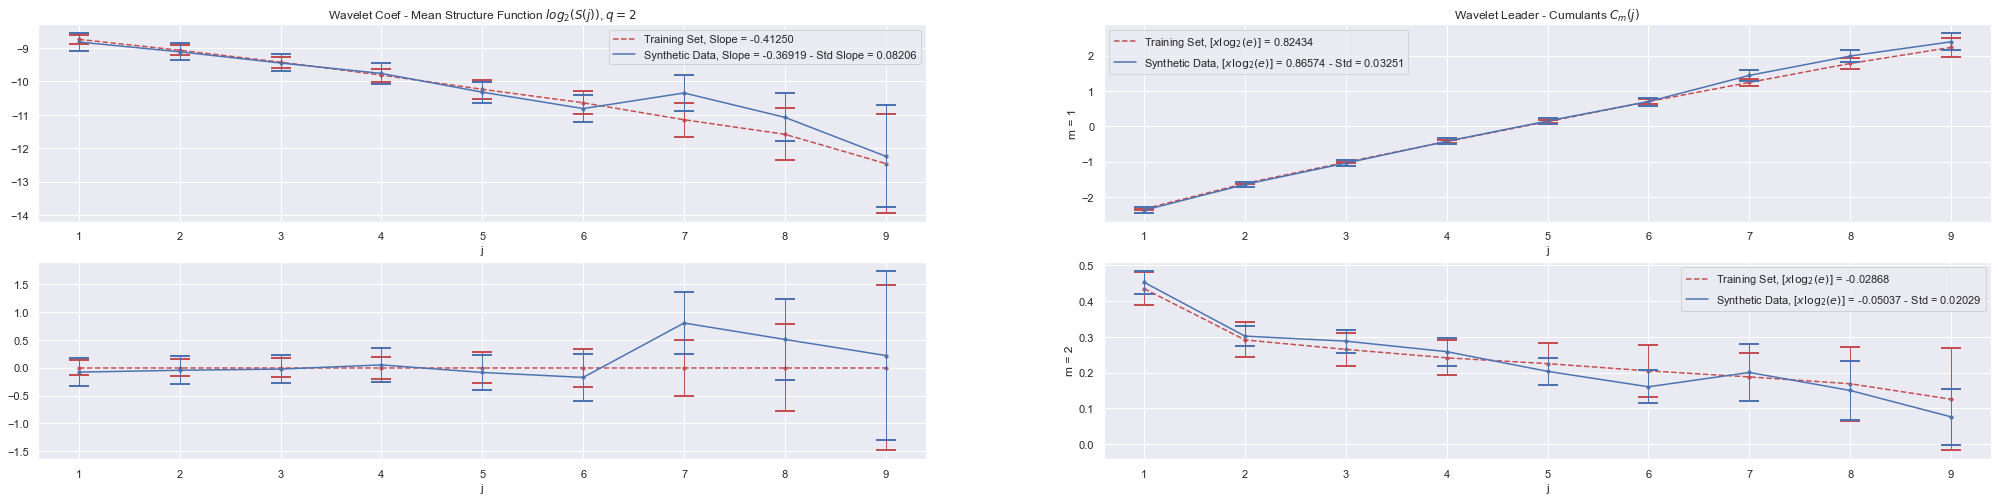

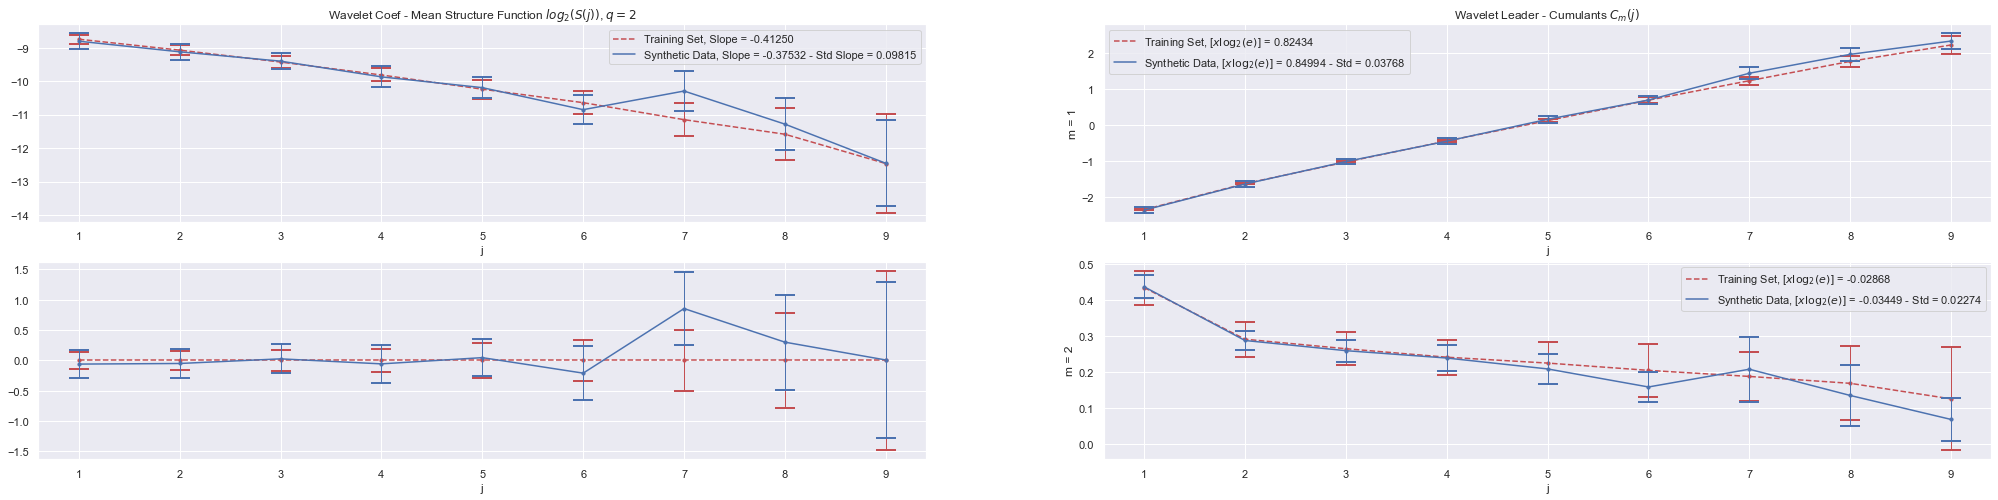

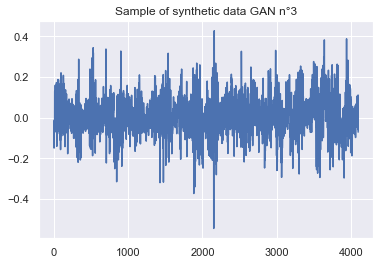

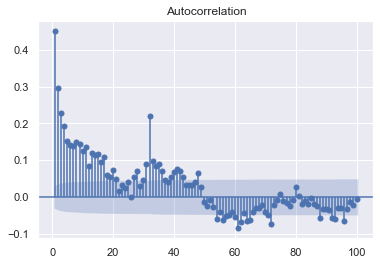

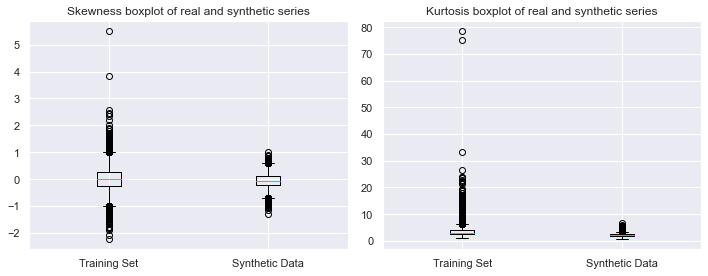

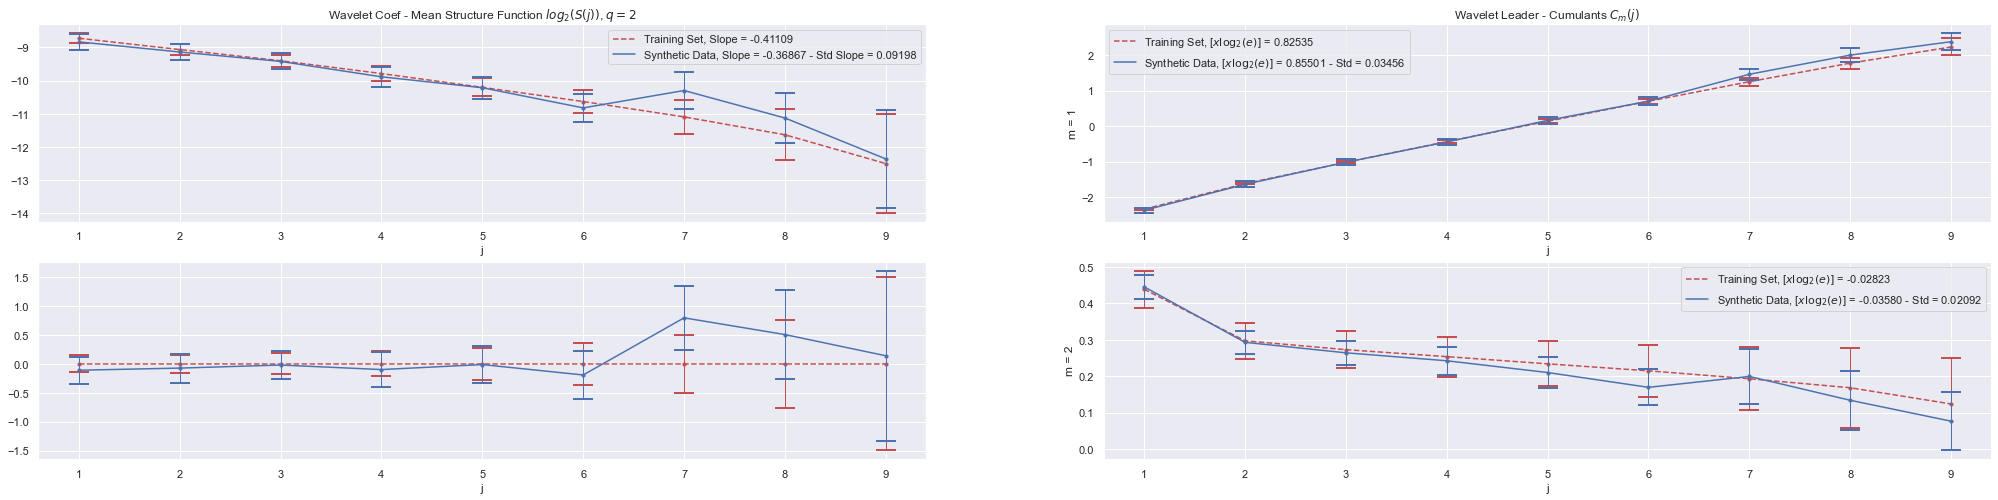

In [11]:
generators512, discriminators512, trainers512, synthetic_datas512, plot_result_sf512, plot_result_m512 = complet_training(n, '2022-07-09_conv0/32', '\\training_set_mrw_0.8_0.03.csv', latent_dim, ts_dim, epochs, device)
torch.cuda.empty_cache()

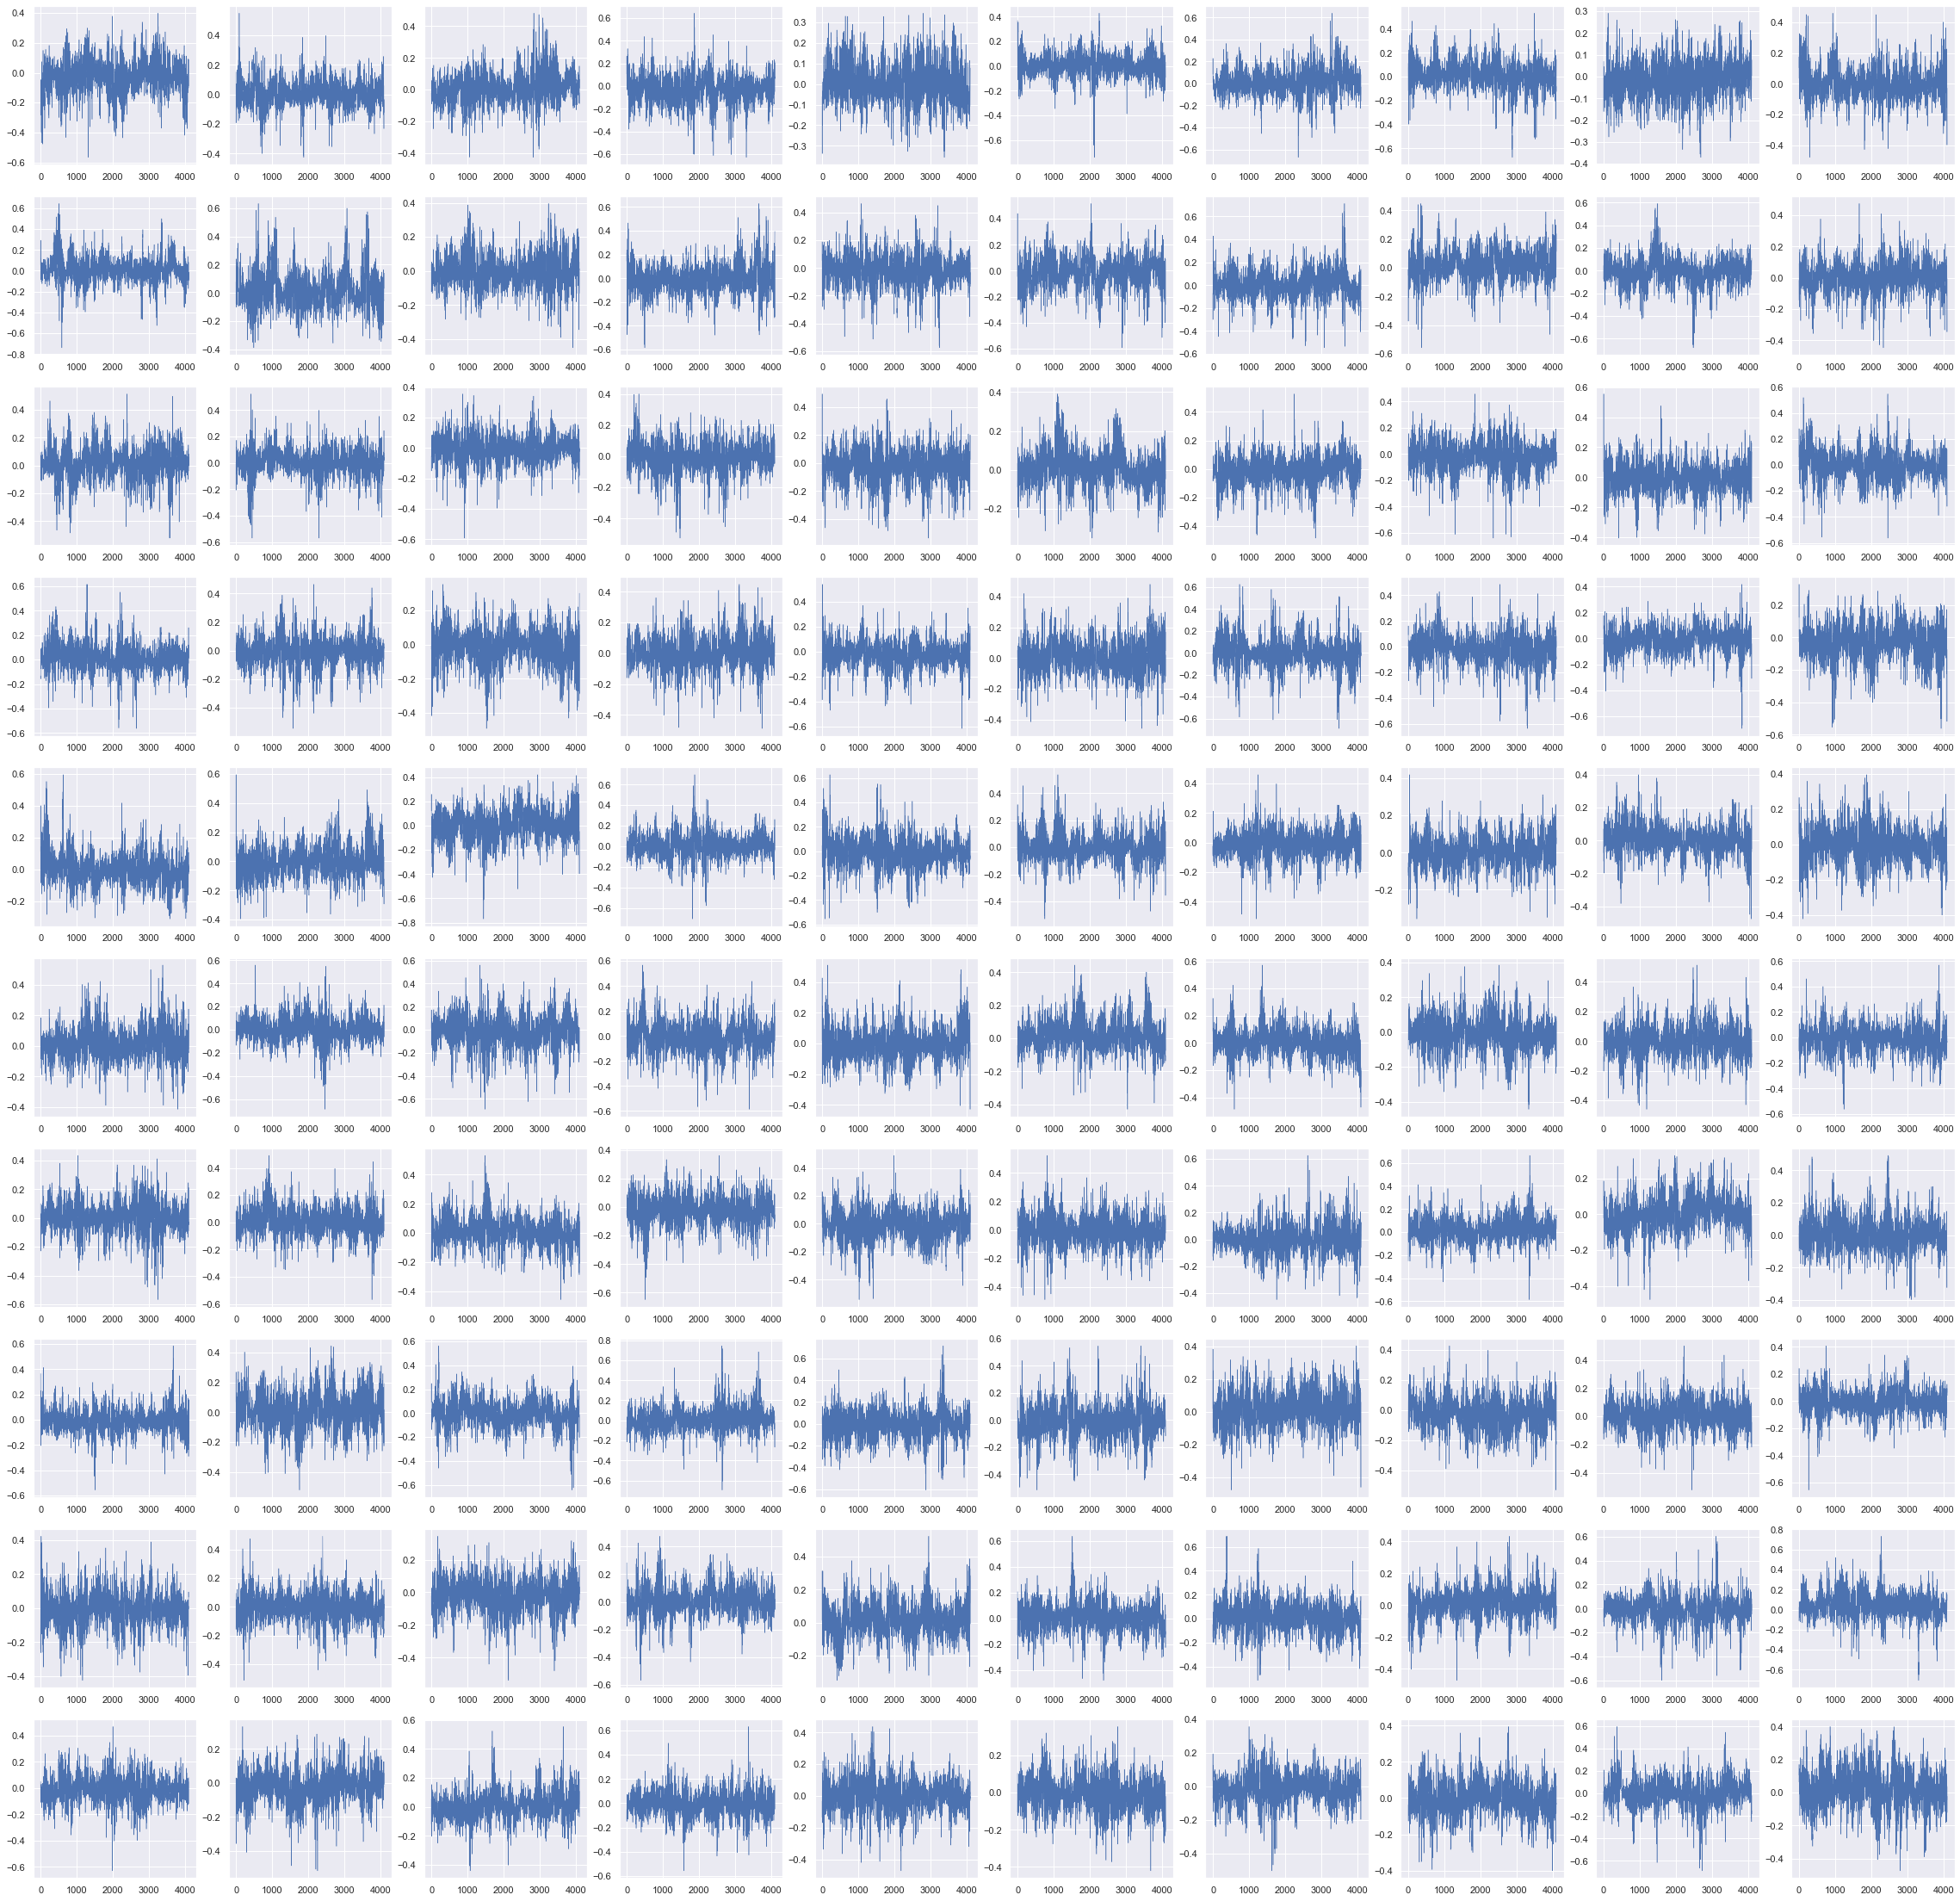

In [12]:
plt.figure(1, figsize =(40,40))
with torch.no_grad():
    for i in range (100):
        plt.subplot(10,10,i+1)
        plt.plot(synthetic_datas512[0][np.random.randint(low = 0, high = 10000)].cpu(), linewidth = 0.5)

### Case 2: kernel_size = 32

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv0 = nn.Conv1d(1, 1, kernel_size = 32, padding = 'same')
        self.batch0 = nn.BatchNorm1d(1)
        
        self.conv1 = nn.ConvTranspose1d(8, 4, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch1 = nn.BatchNorm1d(4)
        self.conv2 = nn.ConvTranspose1d(4, 2, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch2 = nn.BatchNorm1d(2)
        self.conv3 = nn.ConvTranspose1d(2, 1, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch3 = nn.BatchNorm1d(1)
        self.tanh = btanha()


    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = self.conv0(x)
        x = self.batch0(x)
        x = F.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], 8, x.shape[2]//8)

        x = self.batch1(self.conv1(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch2(self.conv2(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch3(self.conv3(x))
        x = x.squeeze()
        return self.tanh(x)
    


class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.ts_dim = ts_dim
        self.conv1 = nn.Conv1d(1, 32, kernel_size = 7, padding = 'same')
        self.conv2 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same')
        self.conv3 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same') 
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear(self.ts_dim*8, 50) 
        self.dense2 = nn.Linear(50, 15)
        self.dense3 = nn.Linear(15, 1)    
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.max_pool1d(x,1)
        x = self.flatten(x)
        x = F.leaky_relu(self.dense1(x), 0.2)
        x = F.leaky_relu(self.dense2(x), 0.2)
        return F.leaky_relu(self.dense3(x), 0.2)

In [ ]:
generators32, discriminators32, trainers32, synthetic_datas32, plot_result_sf32, plot_result_m32 = complet_training(n, '2022-07-09_conv0/32', '\\training_set_mrw_0.8_0.03.csv', latent_dim, ts_dim, epochs, device)
torch.cuda.empty_cache()

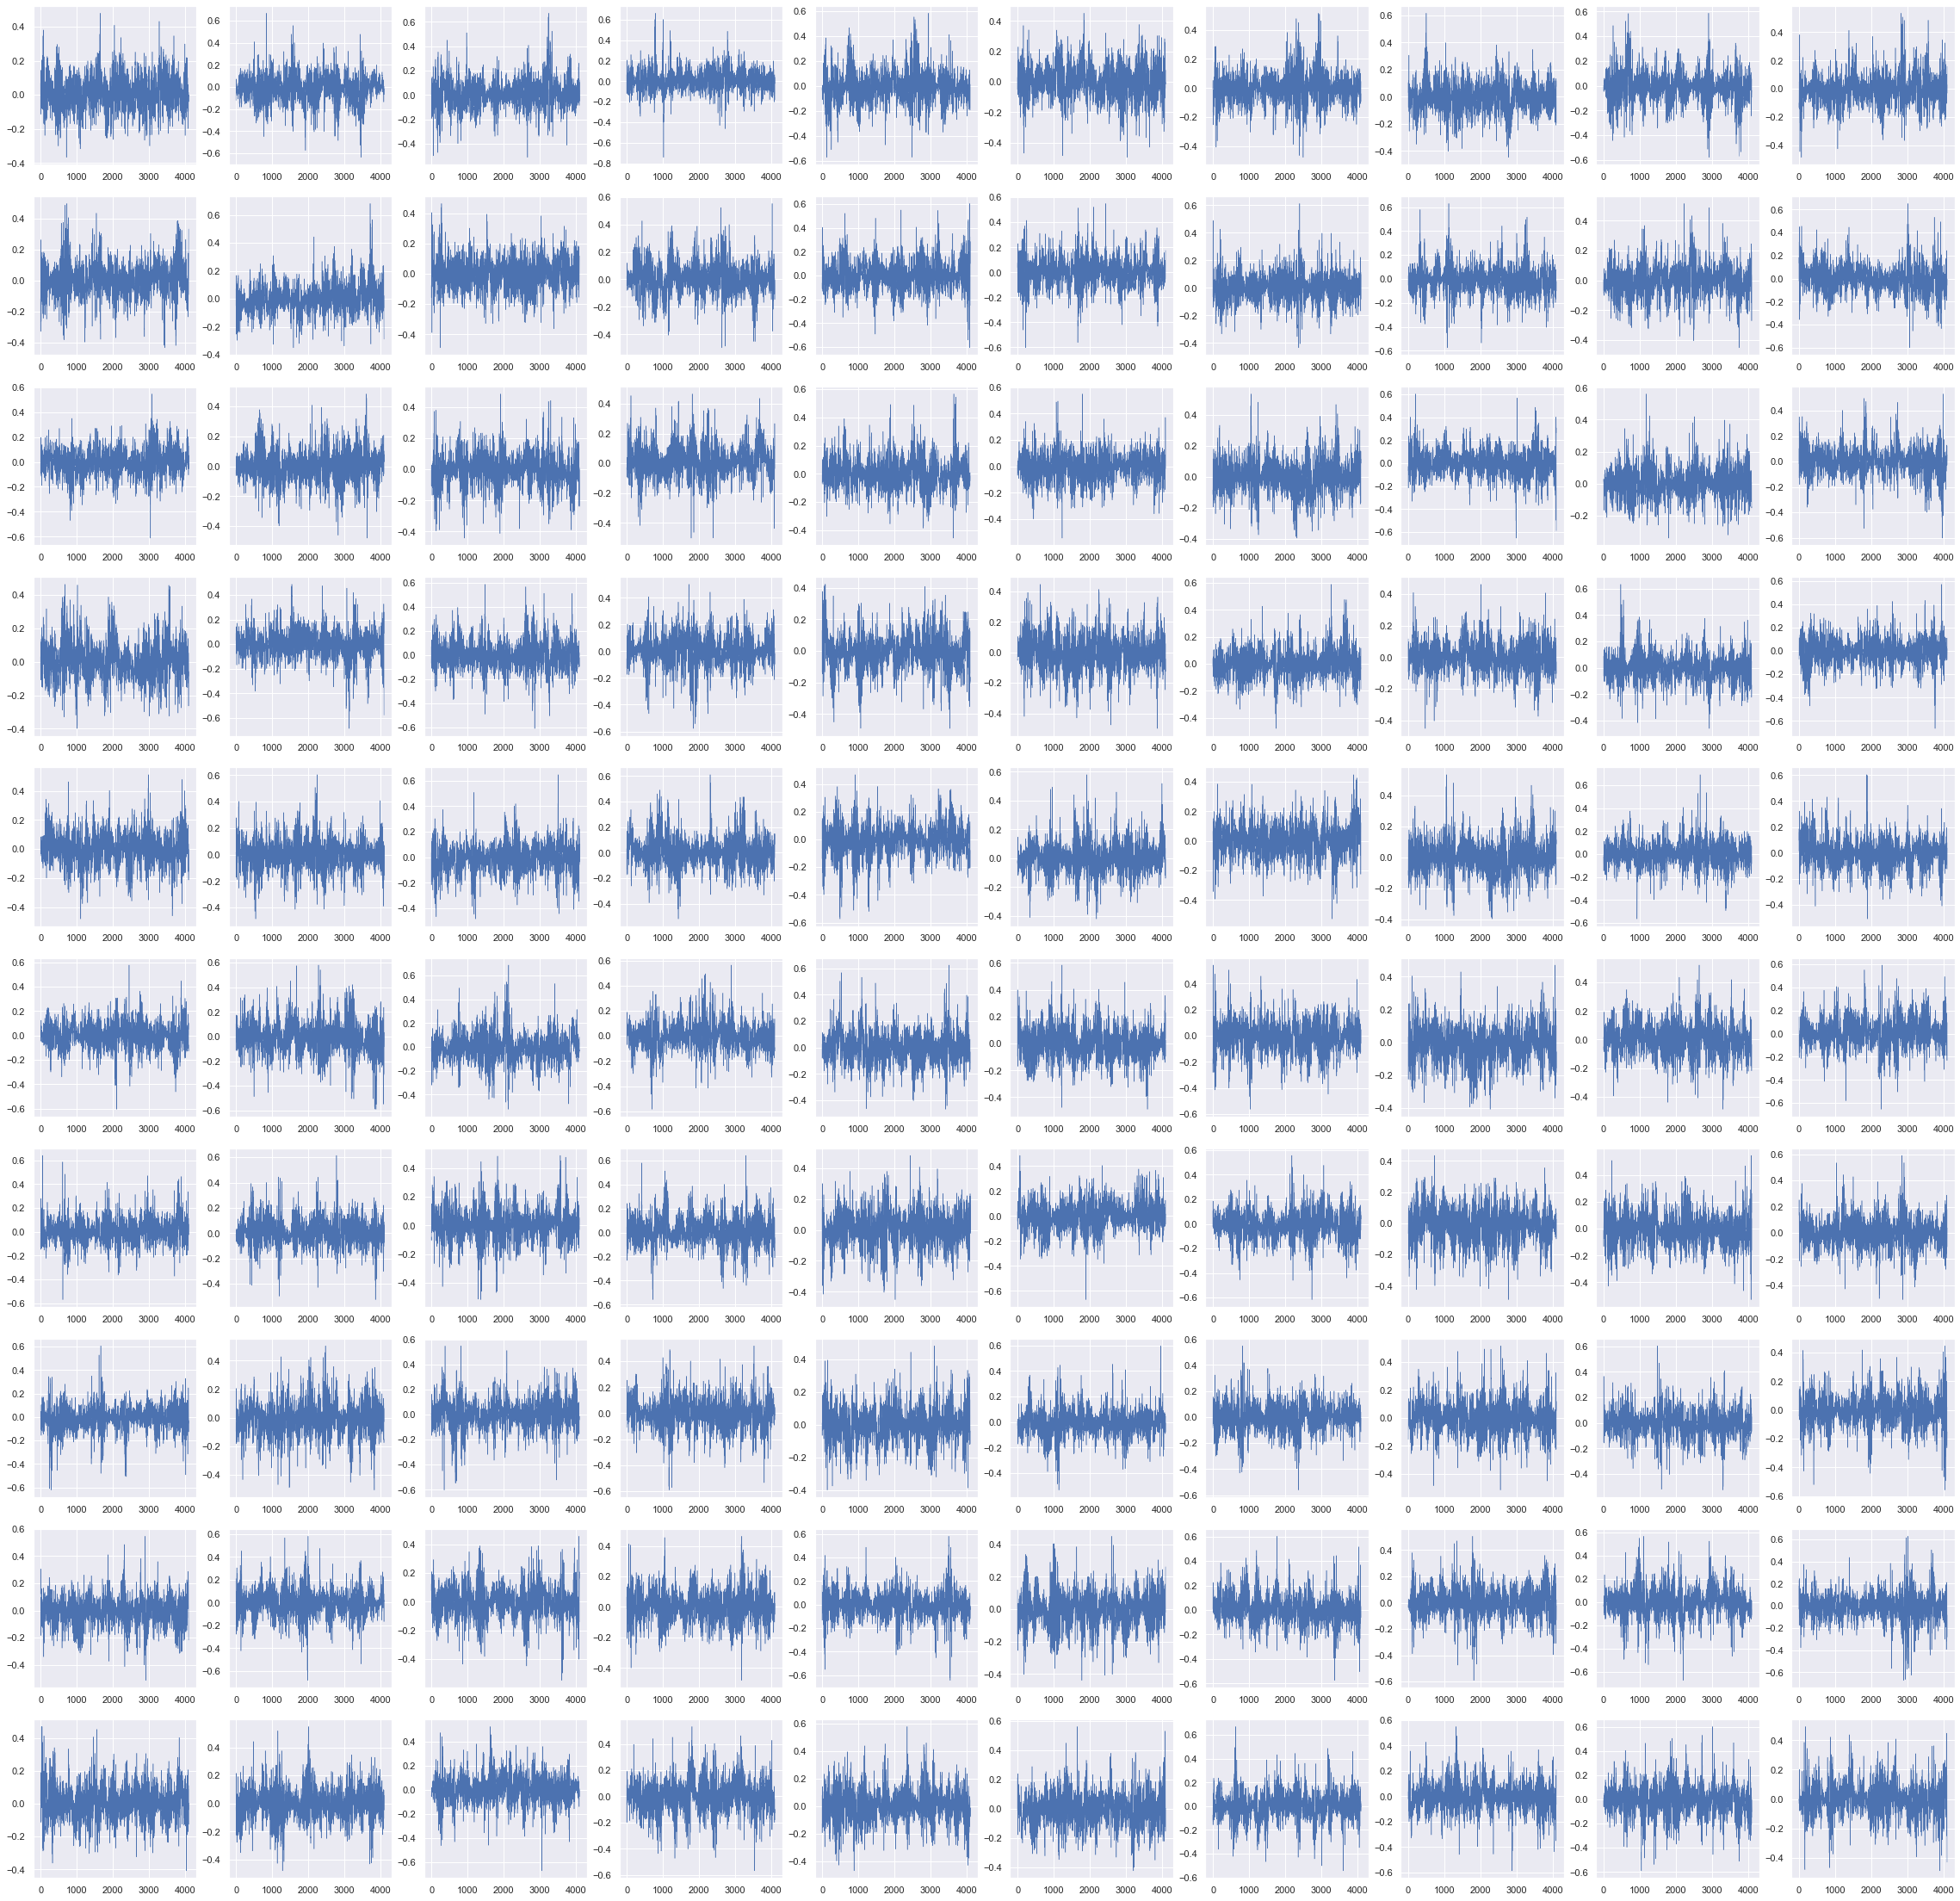

In [9]:
plt.figure(1, figsize =(40,40))
with torch.no_grad():
    for i in range (100):
        plt.subplot(10,10,i+1)
        plt.plot(synthetic_datas32[0][np.random.randint(low = 0, high = 10000)].cpu(), linewidth = 0.5)

### Comparison

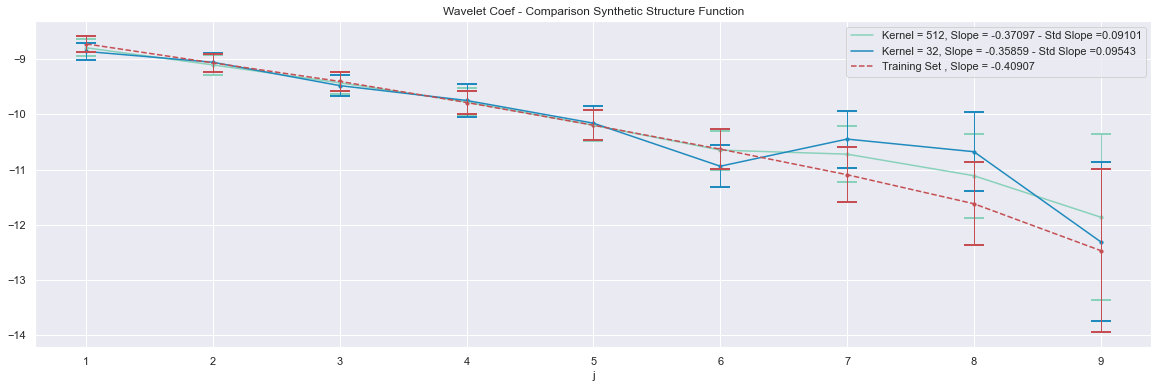

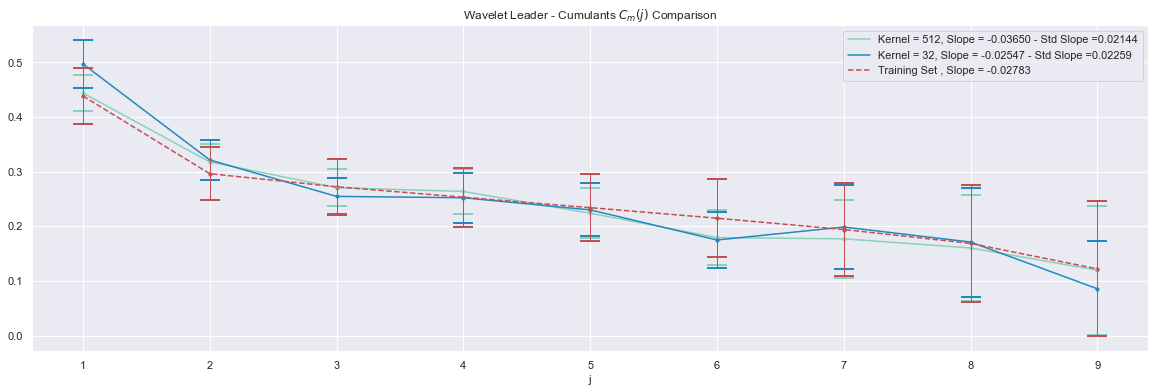

In [14]:
j = plot_result_sf512[0].j

cmap = plt.get_cmap('YlGnBu', 15)

plt.figure(1, figsize=(20, 6)) 
# 512
plt.plot(j, plot_result_sf512[0].wavelet_result_synthetic[0], color = cmap(5), label = 'Kernel = 512, Slope = ' +'%.5f' % (plot_result_sf512[0].wavelet_slope_synthetic) + ' - Std Slope =' +'%.5f' % (plot_result_sf512[0].wavelet_std_slope_synthetic))
plt.scatter(j, plot_result_sf512[0].wavelet_result_synthetic[0], color = cmap(5),s=10)
plt.errorbar(j, plot_result_sf512[0].wavelet_result_synthetic[0], yerr = plot_result_sf512[0].wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(5), elinewidth = 1, capthick = 2)

# 32
plt.plot(j, plot_result_sf32[0].wavelet_result_synthetic[0], color = cmap(9), label = 'Kernel = 32, Slope = ' +'%.5f' % (plot_result_sf32[0].wavelet_slope_synthetic) + ' - Std Slope =' +'%.5f' % (plot_result_sf32[0].wavelet_std_slope_synthetic))
plt.scatter(j, plot_result_sf32[0].wavelet_result_synthetic[0], color = cmap(9),s=10)
plt.errorbar(j, plot_result_sf32[0].wavelet_result_synthetic[0], yerr = plot_result_sf32[0].wavelet_result_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(9), elinewidth = 1, capthick = 2)

#trainsing set 
plt.plot(j, plot_result_sf512[0].wavelet_result_data[0], 'r--', label = 'Training Set ' +', Slope = ' +'%.5f' % (plot_result_sf512[0].wavelet_slope_data))
plt.scatter(j, plot_result_sf512[0].wavelet_result_data[0], color = 'r',s=10)
plt.errorbar(j, plot_result_sf512[0].wavelet_result_data[0], yerr = plot_result_sf512[0].wavelet_result_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.xlabel('j')
plt.title('Wavelet Coef - Comparison Synthetic Structure Function')
plt.legend()

plt.figure(2, figsize=(20, 6)) 
# 512
plt.plot(j, plot_result_sf512[0].cumul_result2_synthetic[0], color = cmap(5), label = 'Kernel = 512, Slope = ' +'%.5f' % (plot_result_sf512[0].cumul_slope_synthetic[1]) + ' - Std Slope =' +'%.5f' % (plot_result_sf512[0].cumul_std_slope_synthetic[1]))
plt.scatter(j, plot_result_sf512[0].cumul_result2_synthetic[0], color = cmap(5),s=10)
plt.errorbar(j, plot_result_sf512[0].cumul_result2_synthetic[0], yerr = plot_result_sf512[0].cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(5), elinewidth = 1, capthick = 2)

# 32
plt.plot(j, plot_result_sf32[0].cumul_result2_synthetic[0], color = cmap(9), label = 'Kernel = 32, Slope = ' +'%.5f' % (plot_result_sf32[0].cumul_slope_synthetic[1]) + ' - Std Slope =' +'%.5f' % (plot_result_sf32[0].cumul_std_slope_synthetic[1]))
plt.scatter(j, plot_result_sf32[0].cumul_result2_synthetic[0], color = cmap(9),s=10)
plt.errorbar(j, plot_result_sf32[0].cumul_result2_synthetic[0], yerr = plot_result_sf32[0].cumul_result2_synthetic[1], fmt = 'none', capsize = 10, ecolor = cmap(9), elinewidth = 1, capthick = 2)

#trainsing set plt.plot(j, plot_result_sf512[0].cumul_result2_data[0], 'r--', label = 'Training Set ' +', Slope = ' +'%.5f' % (plot_result_sf512[0].cumul_slope_data[1]))plt.scatter(j, plot_result_sf512[0].cumul_result2_data[0], color = 'r',s=10)plt.errorbar(j, plot_result_sf512[0].cumul_result2_data[0], yerr = plot_result_sf512[0].cumul_result2_data[1], fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.xlabel('j')
plt.title('Wavelet Leader - Cumulants $C_m (j)$ Comparison')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Kurtosis boxplot of training set and synthetic series')

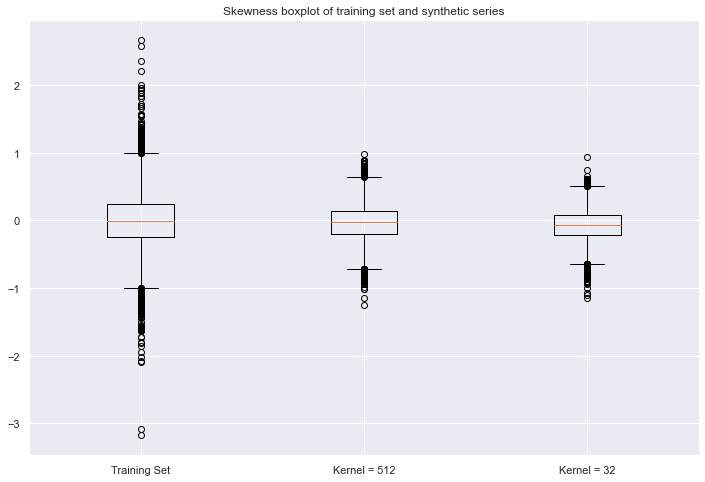

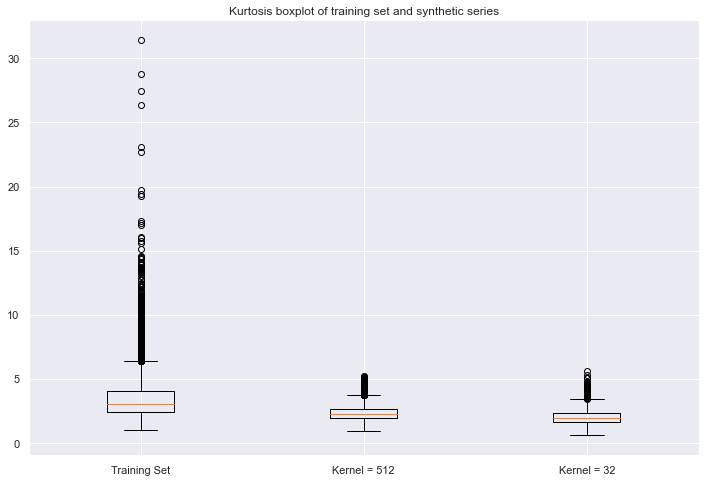

In [15]:
plt.figure(1, figsize = (12,8))
plt.boxplot([plot_result_m512[0].moment_data_train['skew'], plot_result_m512[0].moment_synthetic_data['skew'],plot_result_m32[0].moment_synthetic_data['skew']], 
                labels = ['Training Set','Kernel = 512', 'Kernel = 32'] )
plt.title('Skewness boxplot of training set and synthetic series')


plt.figure(2, figsize = (12,8))
plt.boxplot([plot_result_m512[0].moment_data_train['kurtosis'], plot_result_m512[0].moment_synthetic_data['kurtosis'],plot_result_m32[0].moment_synthetic_data['kurtosis']], 
                labels = ['Training Set','Kernel = 512', 'Kernel = 32'] )
plt.title('Kurtosis boxplot of training set and synthetic series')